%%HTML
<link rel="stylesheet" type="text/css" href="style.css">

jupyter nbconvert --to slides Presentation.ipynb --no-input --SlidesExporter.reveal_number='c/t' --SlidesExporter.reveal_scroll=True

In [22]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import mapclassify
import contextily as ctx
import os
import warnings
warnings.filterwarnings('ignore') # Altrimenti appaiono nella presentazione
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams["figure.dpi"] = 300
%matplotlib inline

In [23]:
filename = 'attentati.parquet'
path = os.path.abspath(os.path.join(os.pardir, "data","parquet"))
tr = pd.read_parquet(os.path.join(path, filename))
#tr.info(verbose=True)


# Terrorismo – Global Terrorism Dataset
Cosa vuol dire terrorismo?

 > Azioni criminali violente premeditate aventi lo scopo di suscitare terrore nella popolazione tra le quali attentati, omicidi, stragi, sequestri, sabotaggi, dirottamenti ed altri eventi […]

## Perchè ho scelto un dataset sul terrorismo globale?

-   Passione per il true crime
-   Testimonianze di mio padre degli Anni di Piombo in Puglia
-   Curiosità storica
-   Colpo di fulmine

## Dove l'ho trovato?

- Inizialmente su [Kaggle](https://www.kaggle.com/datasets/START-UMD/gtd)
- Richiesta alla [Maryland University](https://www.start.umd.edu/gtd/) per i dati fino al 2020

## Com'è strutturato?

-   Contiene dati storici sugli attentati
-   Una grande percentule di attentati ha valori `Unknown`
-   L'ho ridotto a cinque nazioni
-   Ho tolto le colonne con un alto tasso di `NaN` values

## Nelle cinque nazioni che ho selezionato, com'è stato l'andamento degli attacchi?

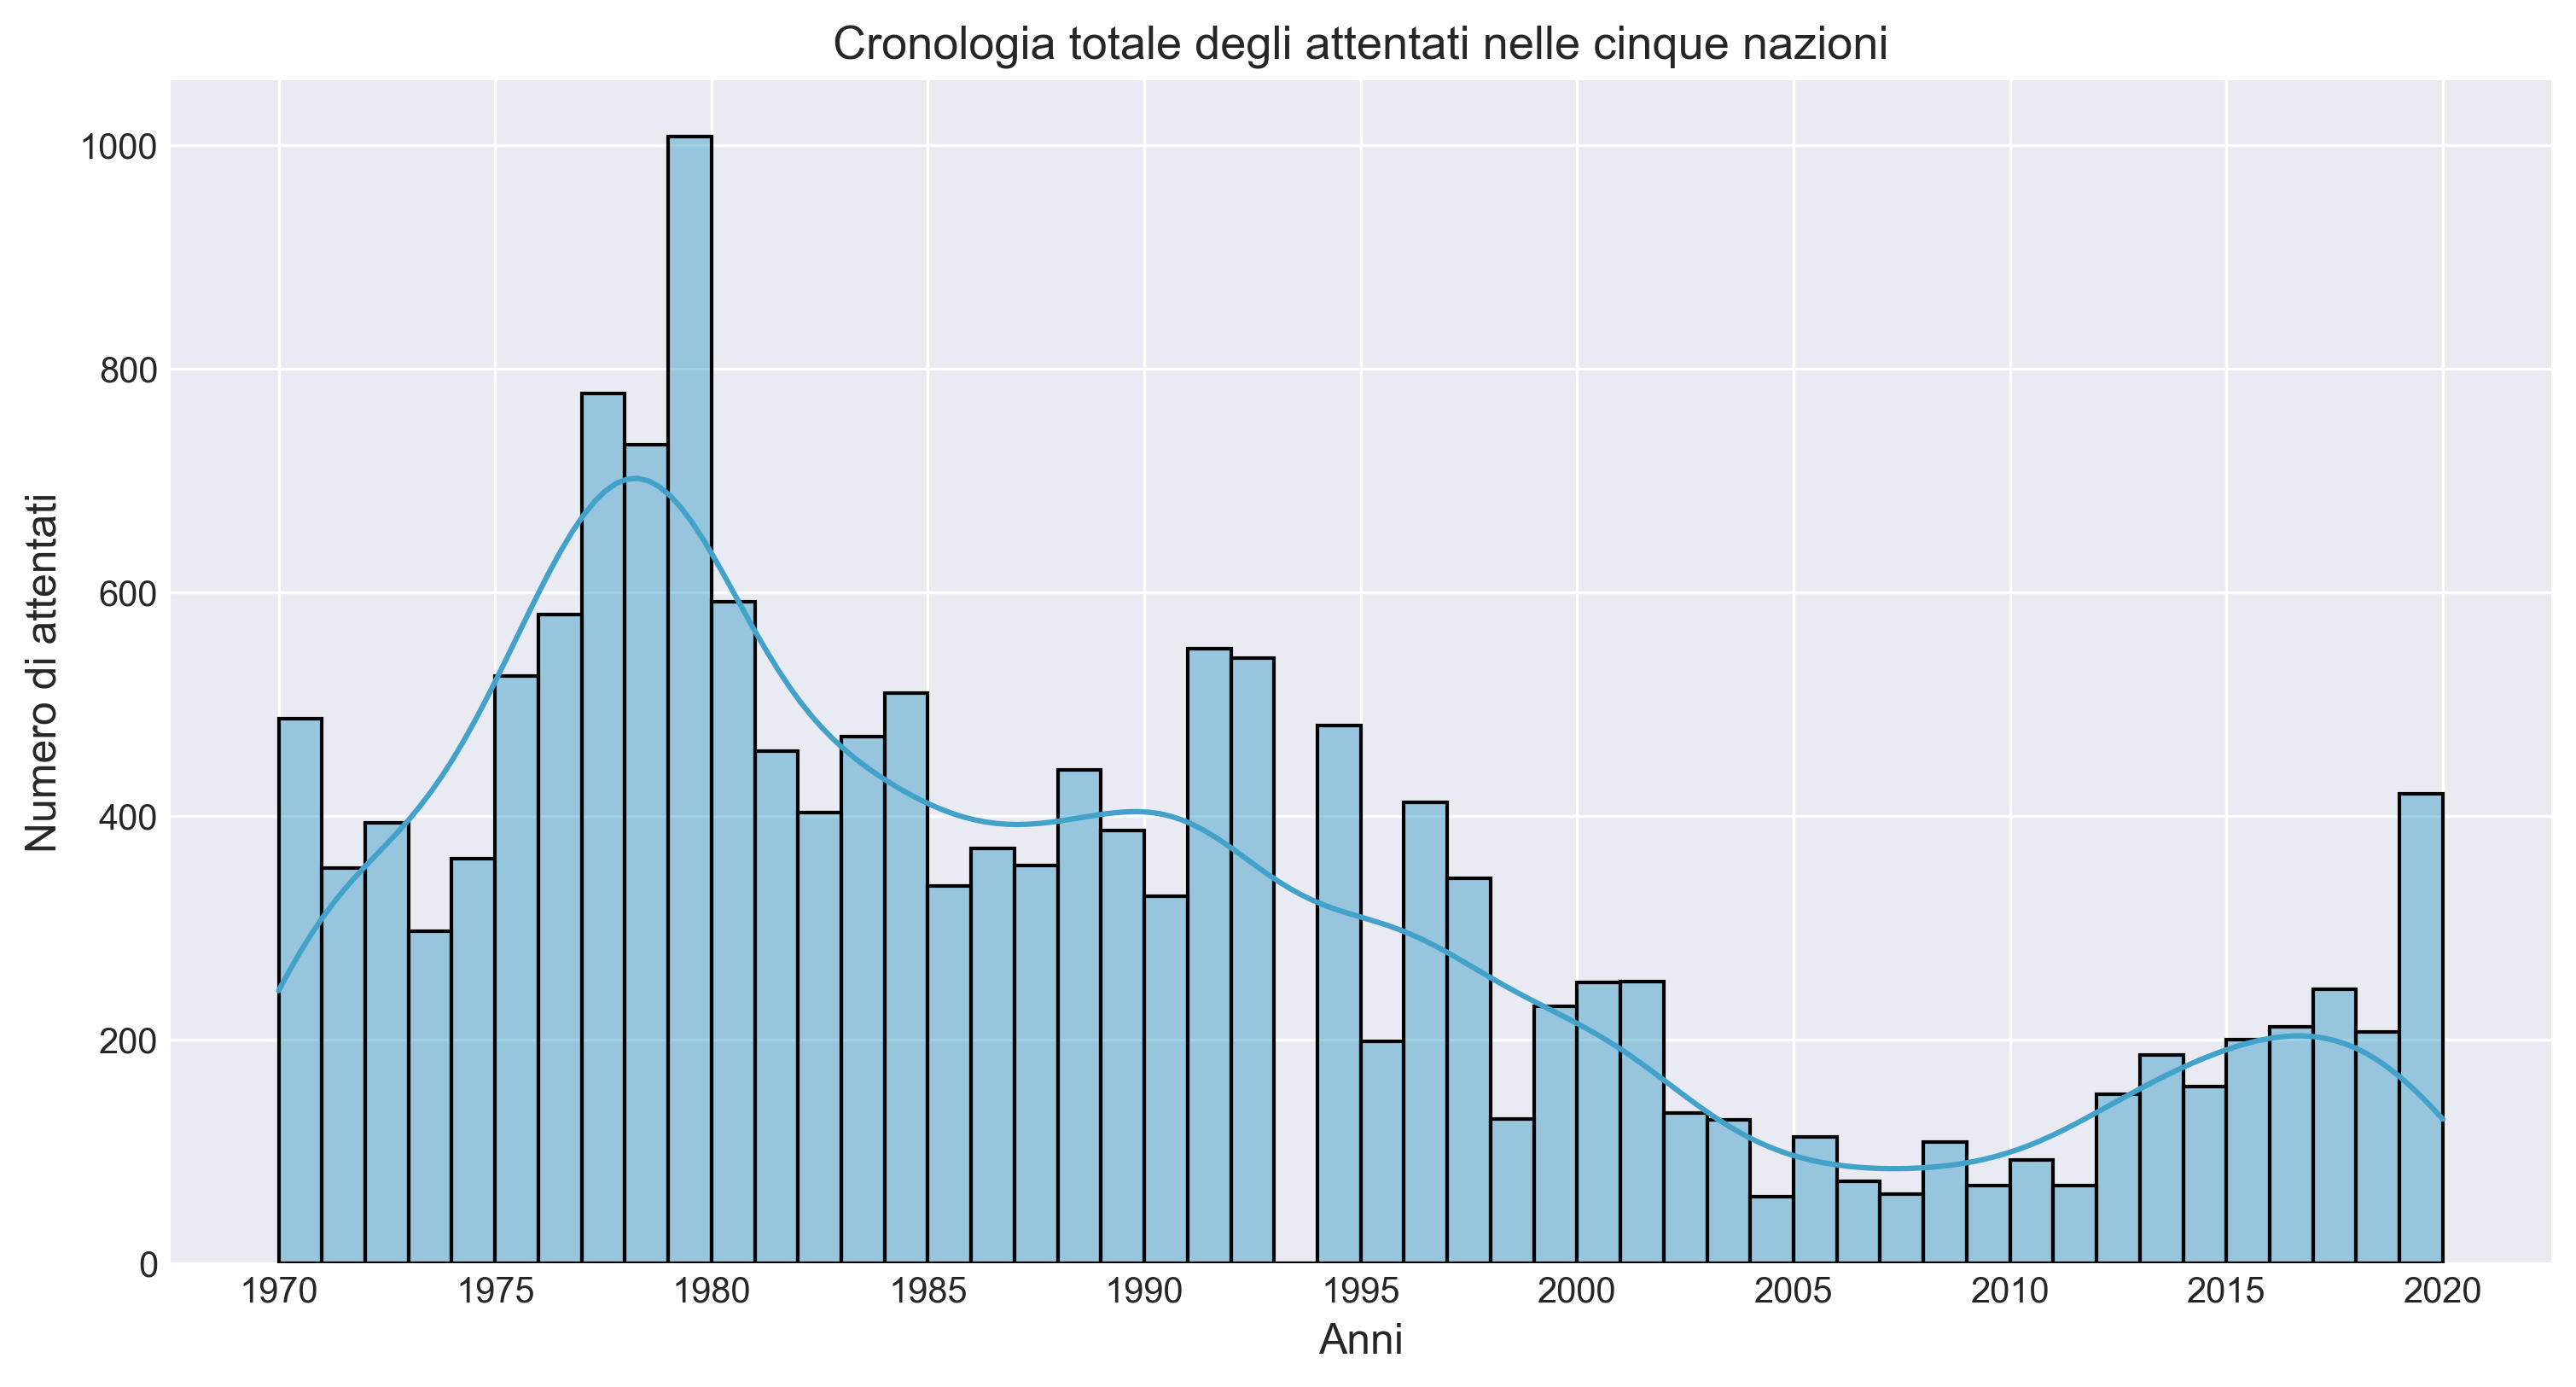

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
s = sns.histplot(tr['year'], kde = True, color="#43a2ca", bins=50)
s.set_title("Cronologia totale degli attentati nelle cinque nazioni", fontsize=13)
s.set(xticks=np.arange(1970,2025,5))
s.set_xlabel("Anni", fontsize=12)
s.set_ylabel("Numero di attentati", fontsize=12)
plt.show()

In [25]:
attentatiNazioni = tr.groupby(['country_name','year']).count()['day']
attentatiNazioni = attentatiNazioni.reset_index().rename(columns={"day":"nAtt"})

# per boxplot e grafici con colori delle nazioni specifici
countries_color = {
    'United States': '#1F77B4',
    'Italy': '#2CA02C', 
    'United Kingdom': '#D62728',
    'Spain': '#FF7F0E',
    'France': '#9467BD'   
}

## Per ogni nazione invece, com'è?

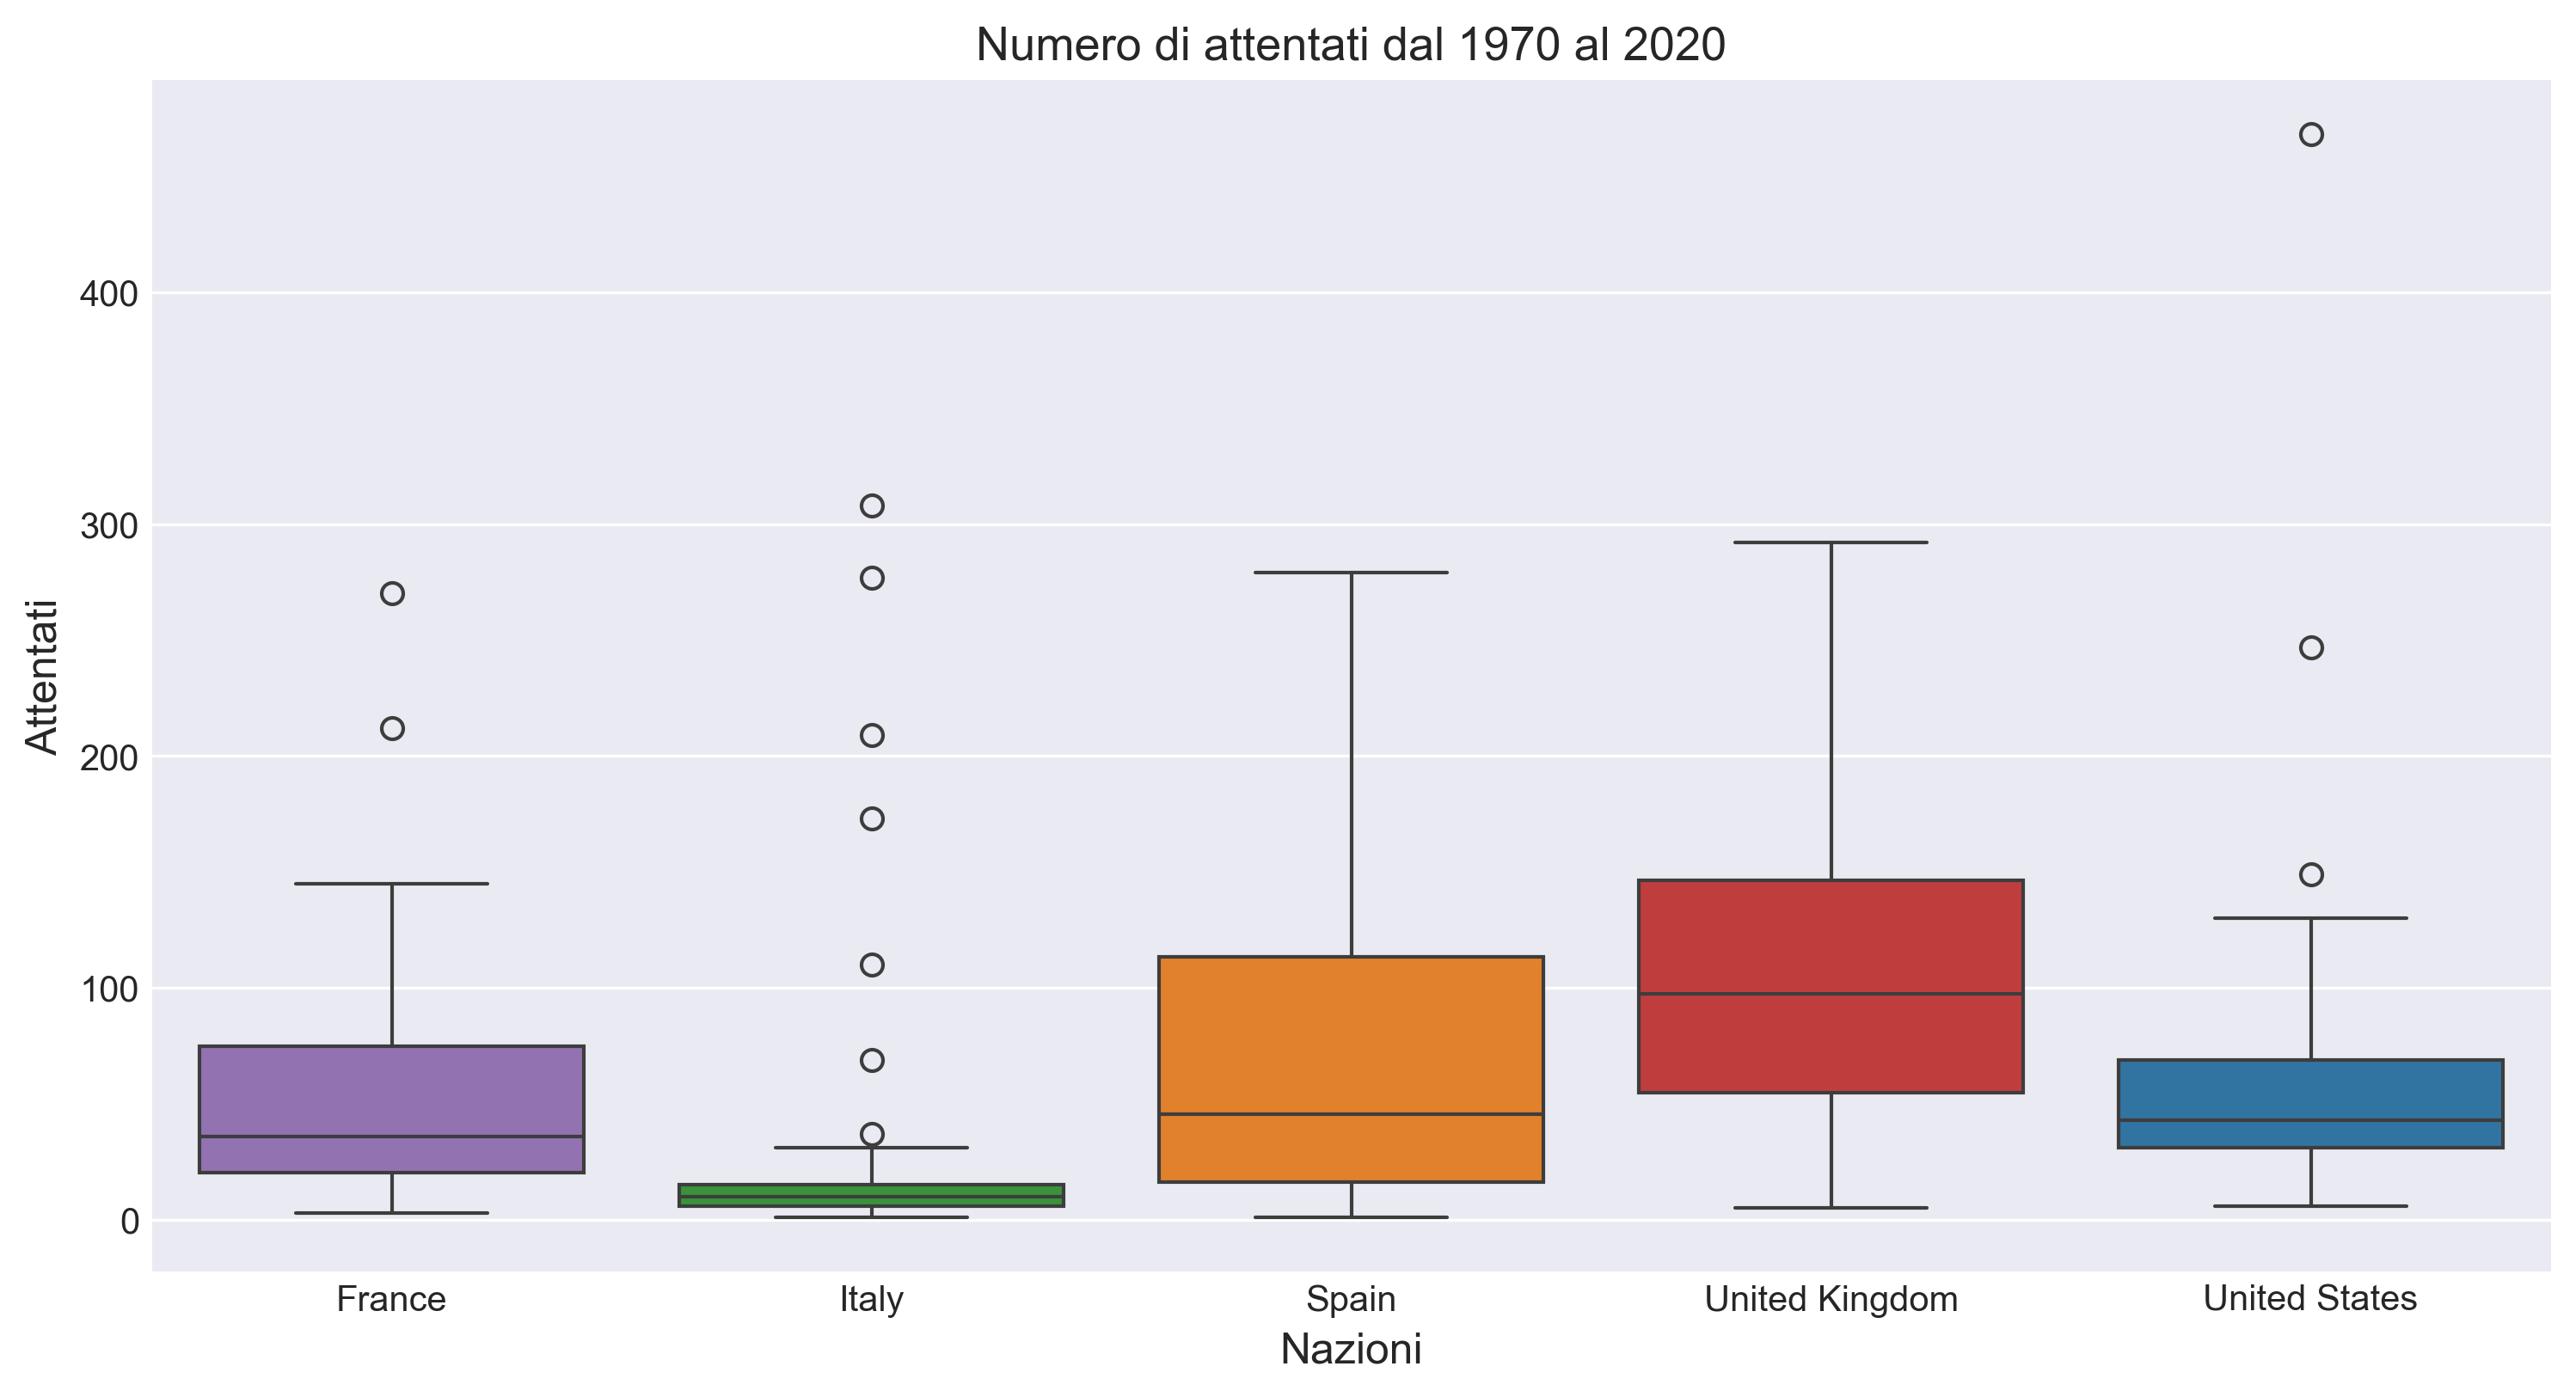

In [26]:
#boxplot
plt.figure(figsize=(12,6))
ax = sns.boxplot(attentatiNazioni, x="country_name", y="nAtt", hue="country_name", palette=countries_color, whis=2)
ax.set_xlabel("Nazioni", fontsize=12)
ax.set_ylabel("Attentati", fontsize=12)
ax.set_title("Numero di attentati dal 1970 al 2020", fontsize=13)

plt.show()

### E facendo una classifica per numero di attentati, si scopre che:

In [27]:
maxAtNazioni = tr.groupby("country_name").count()['day'].reset_index().rename(columns={"country_name":"Paese", "day":"Numero di attentati"}).sort_values("Numero di attentati", ascending=False)
maxAtNazioni.set_index("Paese", inplace=True)
maxAtNazioni.style.background_gradient(subset=["Numero di attentati"], cmap="YlOrRd", vmin=1603, vmax=5513)


### Durante la fase esplorativa, ho notato una somiglianza:

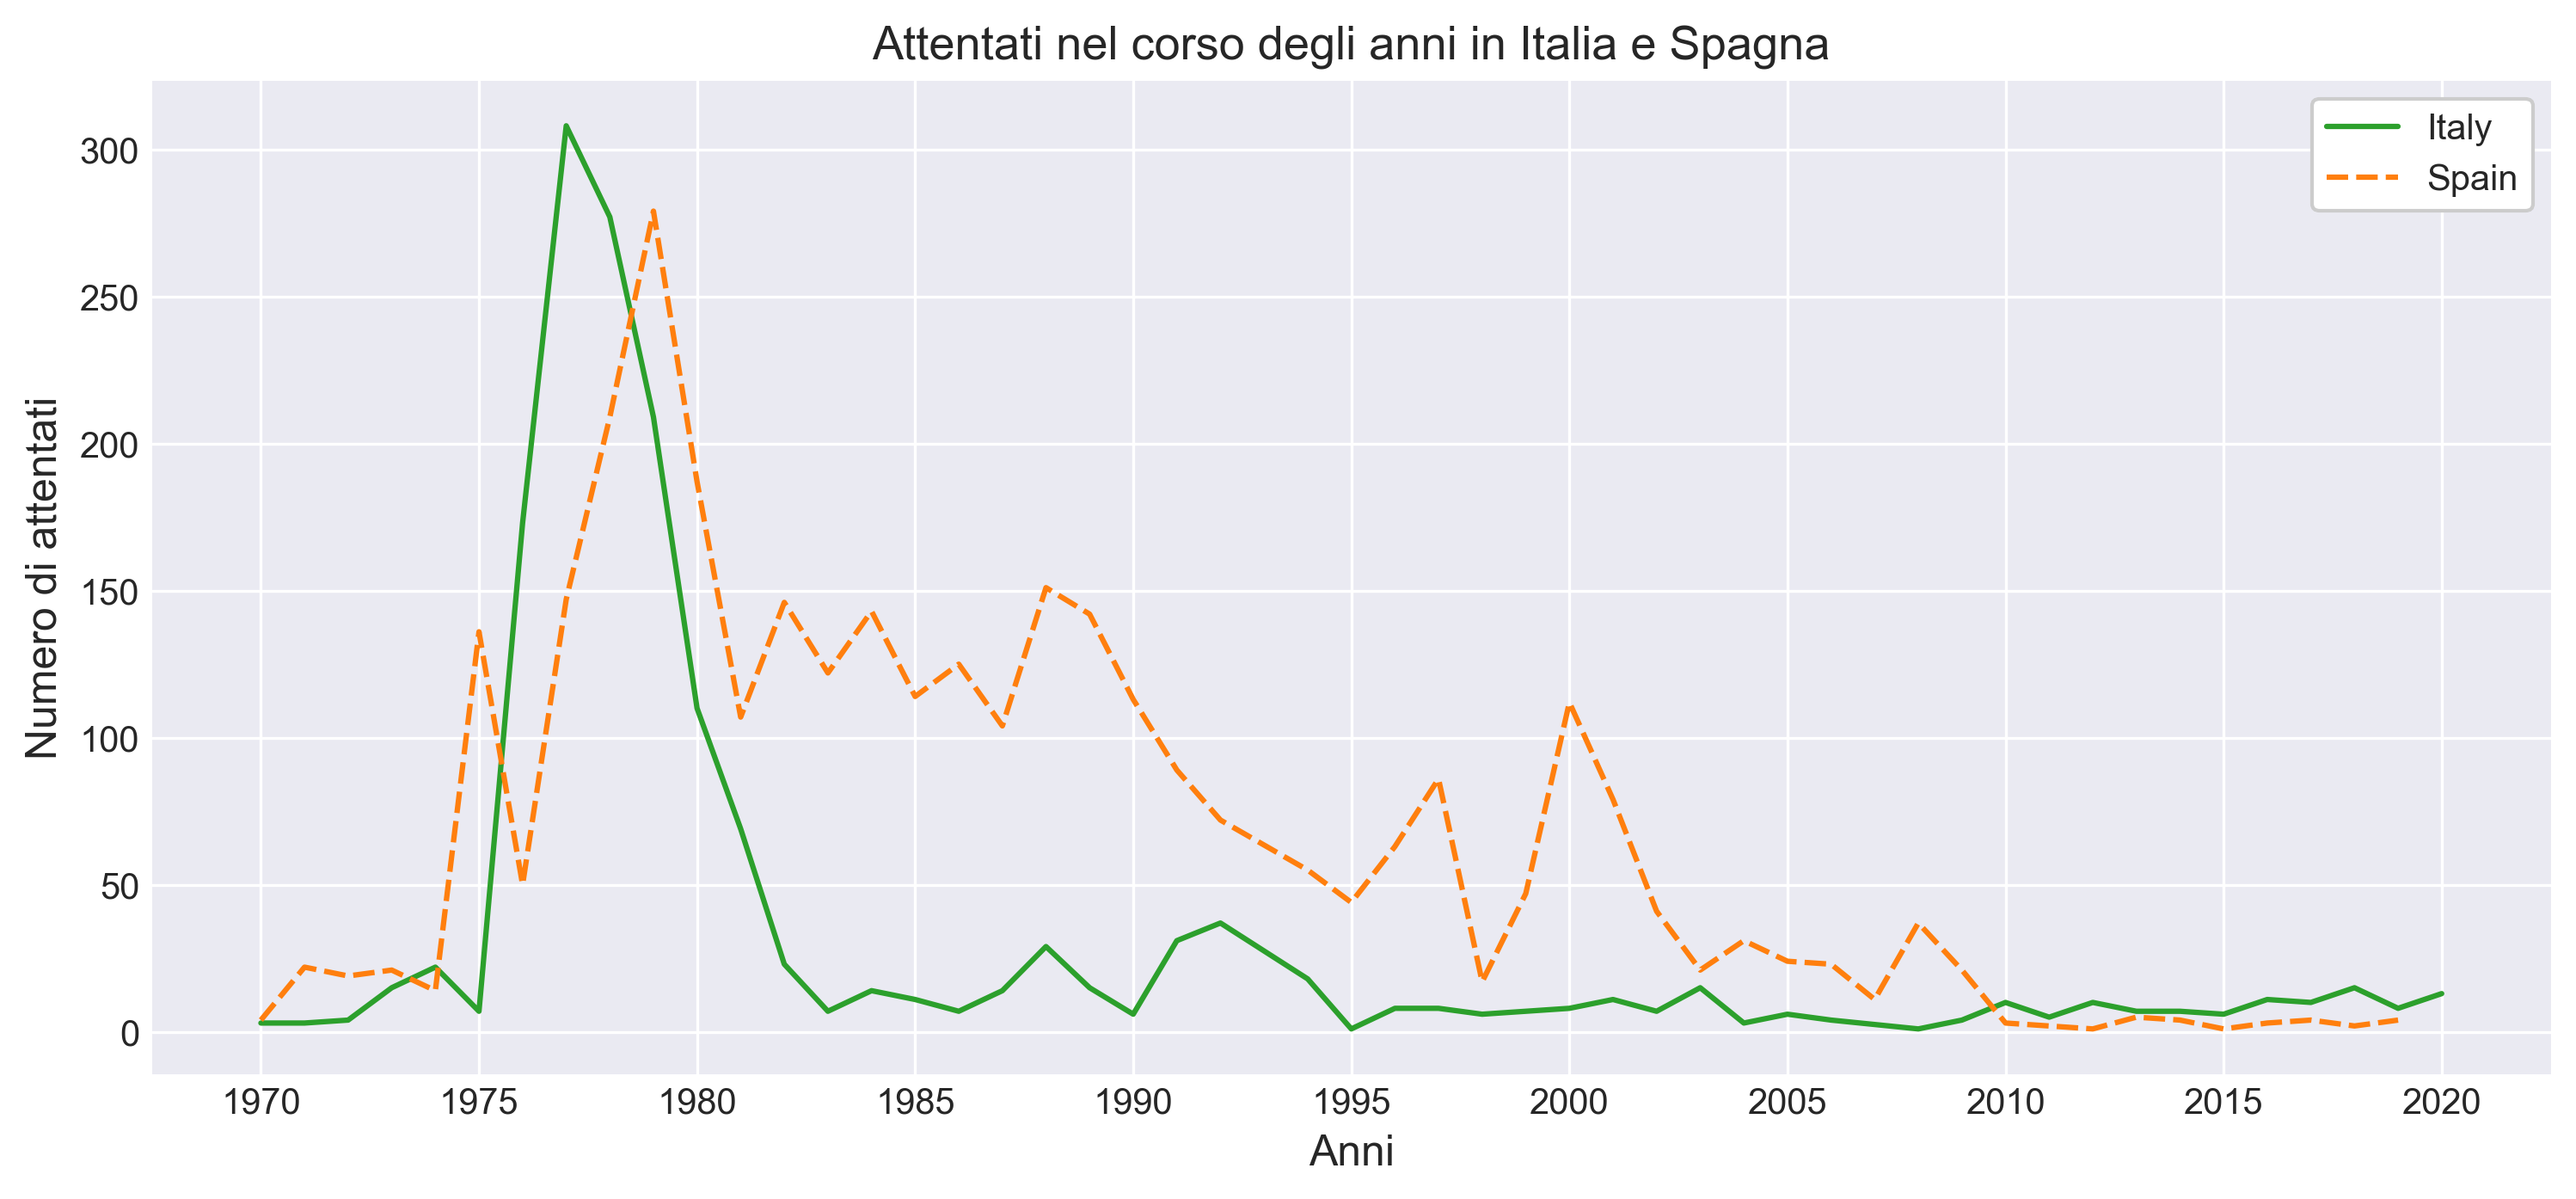

In [28]:
plt.figure(figsize=(12,5))
itaEsp = attentatiNazioni[(attentatiNazioni["country_name"] == "Italy") | (attentatiNazioni["country_name"] == "Spain")]

ax = sns.lineplot(itaEsp, x="year", y="nAtt", hue="country_name", style="country_name", palette=countries_color)
ax.set(xticks=np.arange(1970,2025,5), yticks=np.arange(0,350,50))
ax.set_title("Attentati nel corso degli anni in Italia e Spagna", fontsize=13)
ax.set_ylabel("Numero di attentati", fontsize=12)
ax.set_xlabel("Anni", fontsize=12)
plt.legend(frameon=True, framealpha=1, facecolor="white")

plt.show()

Andando allora ad analizzare gli anni dal 1974 al 1985, ho scoperto che

In [29]:
gSpainAtt = tr[(tr['country_name'] == 'Spain') & ((tr['year'] > 1974) & (tr['year'] < 1985))].groupby('gname').count()['day'].reset_index().rename(columns={"day":"nAtt"}).sort_values("nAtt", ascending=False).head(10)

gItaAtt = tr[(tr['country_name'] == 'Italy') & ((tr['year'] > 1974) & (tr['year'] < 1985))].groupby('gname').count()['day'].reset_index().rename(columns={"day":"nAtt"}).sort_values("nAtt", ascending=False).head(10)


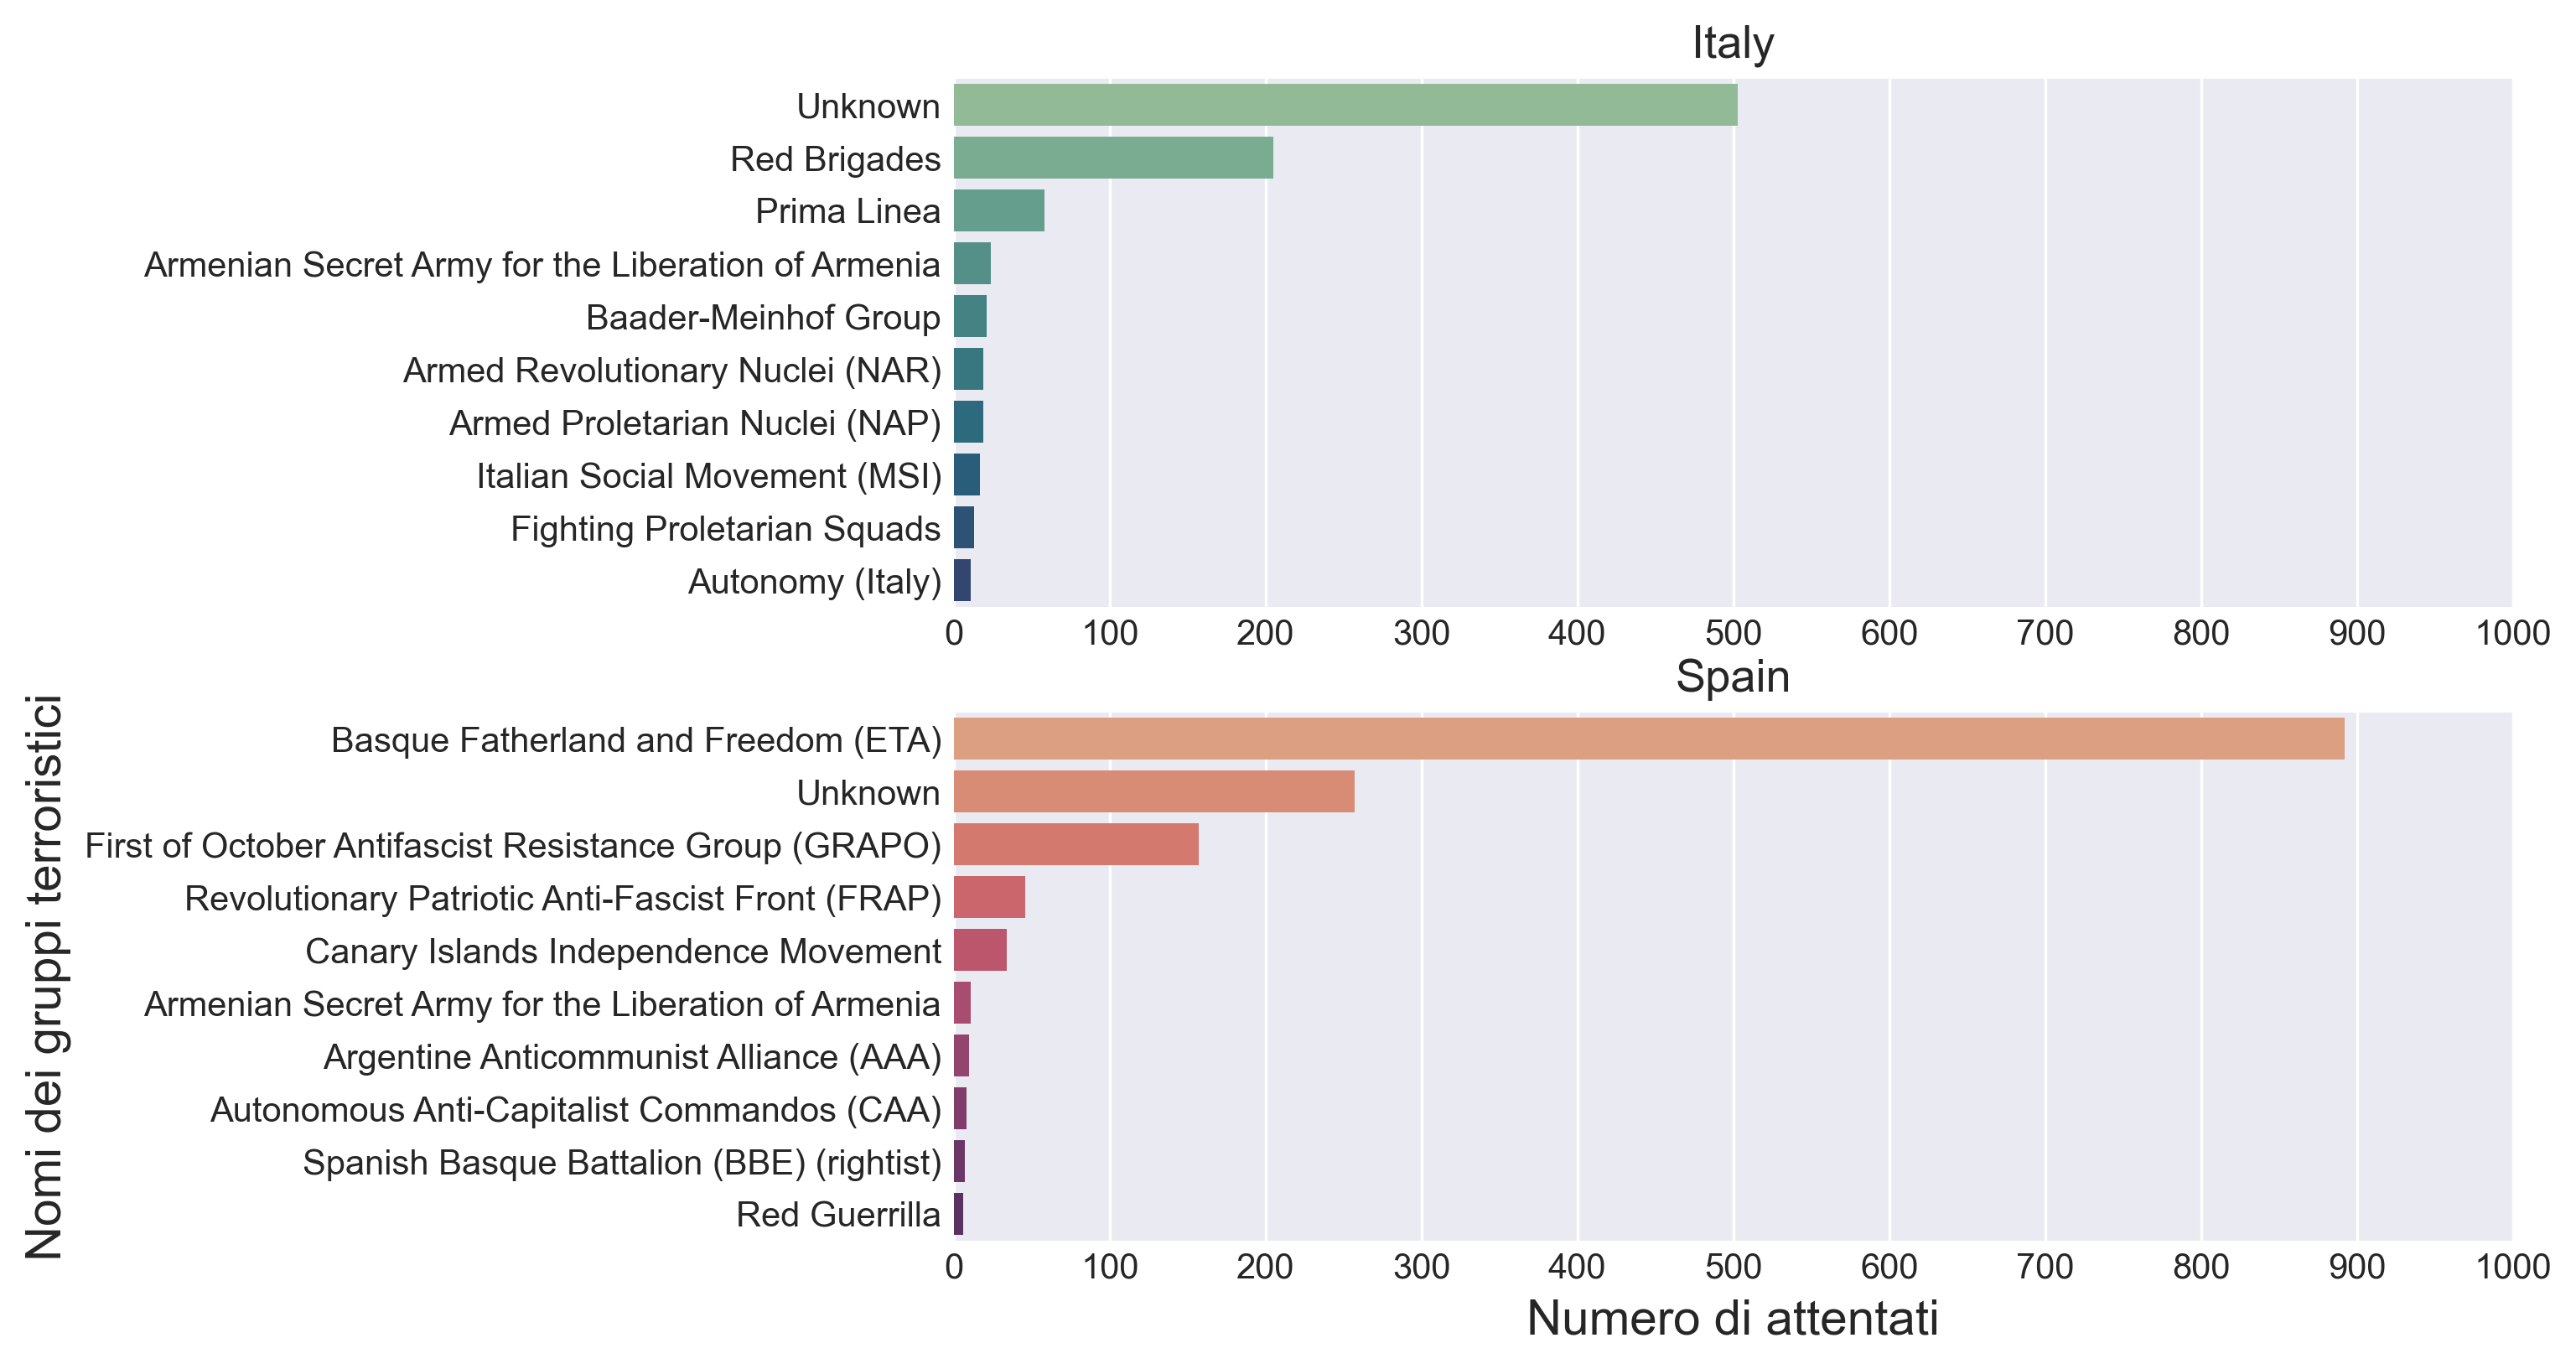

In [30]:
plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
s1 = sns.barplot(gItaAtt, x="nAtt", y="gname", hue="gname", palette="crest", legend=False)
s1.set_xlim(0,1000)
s1.set_ylabel("")
s1.set_xlabel("")
s1.set_title("Italy", fontsize=13)
s1.set(xticks=np.arange(0,1100,100))

plt.subplot(2,1,2)
s2 = sns.barplot(gSpainAtt, x="nAtt", y="gname", hue="gname", palette="flare", legend=False)
s2.set_xlim(0,1000)
s2.set_ylabel("Nomi dei gruppi terroristici", fontsize=14)
s2.set_xlabel("Numero di attentati", fontsize=14)
s2.set_title("Spain", fontsize=13)
s2.set(xticks=np.arange(0,1100,100))


plt.show()

Non c'è nessuna correlazione tra gli attentati in Italia e Spagna

## Quali sono gli attentati più impattanti per Morti/Feriti?

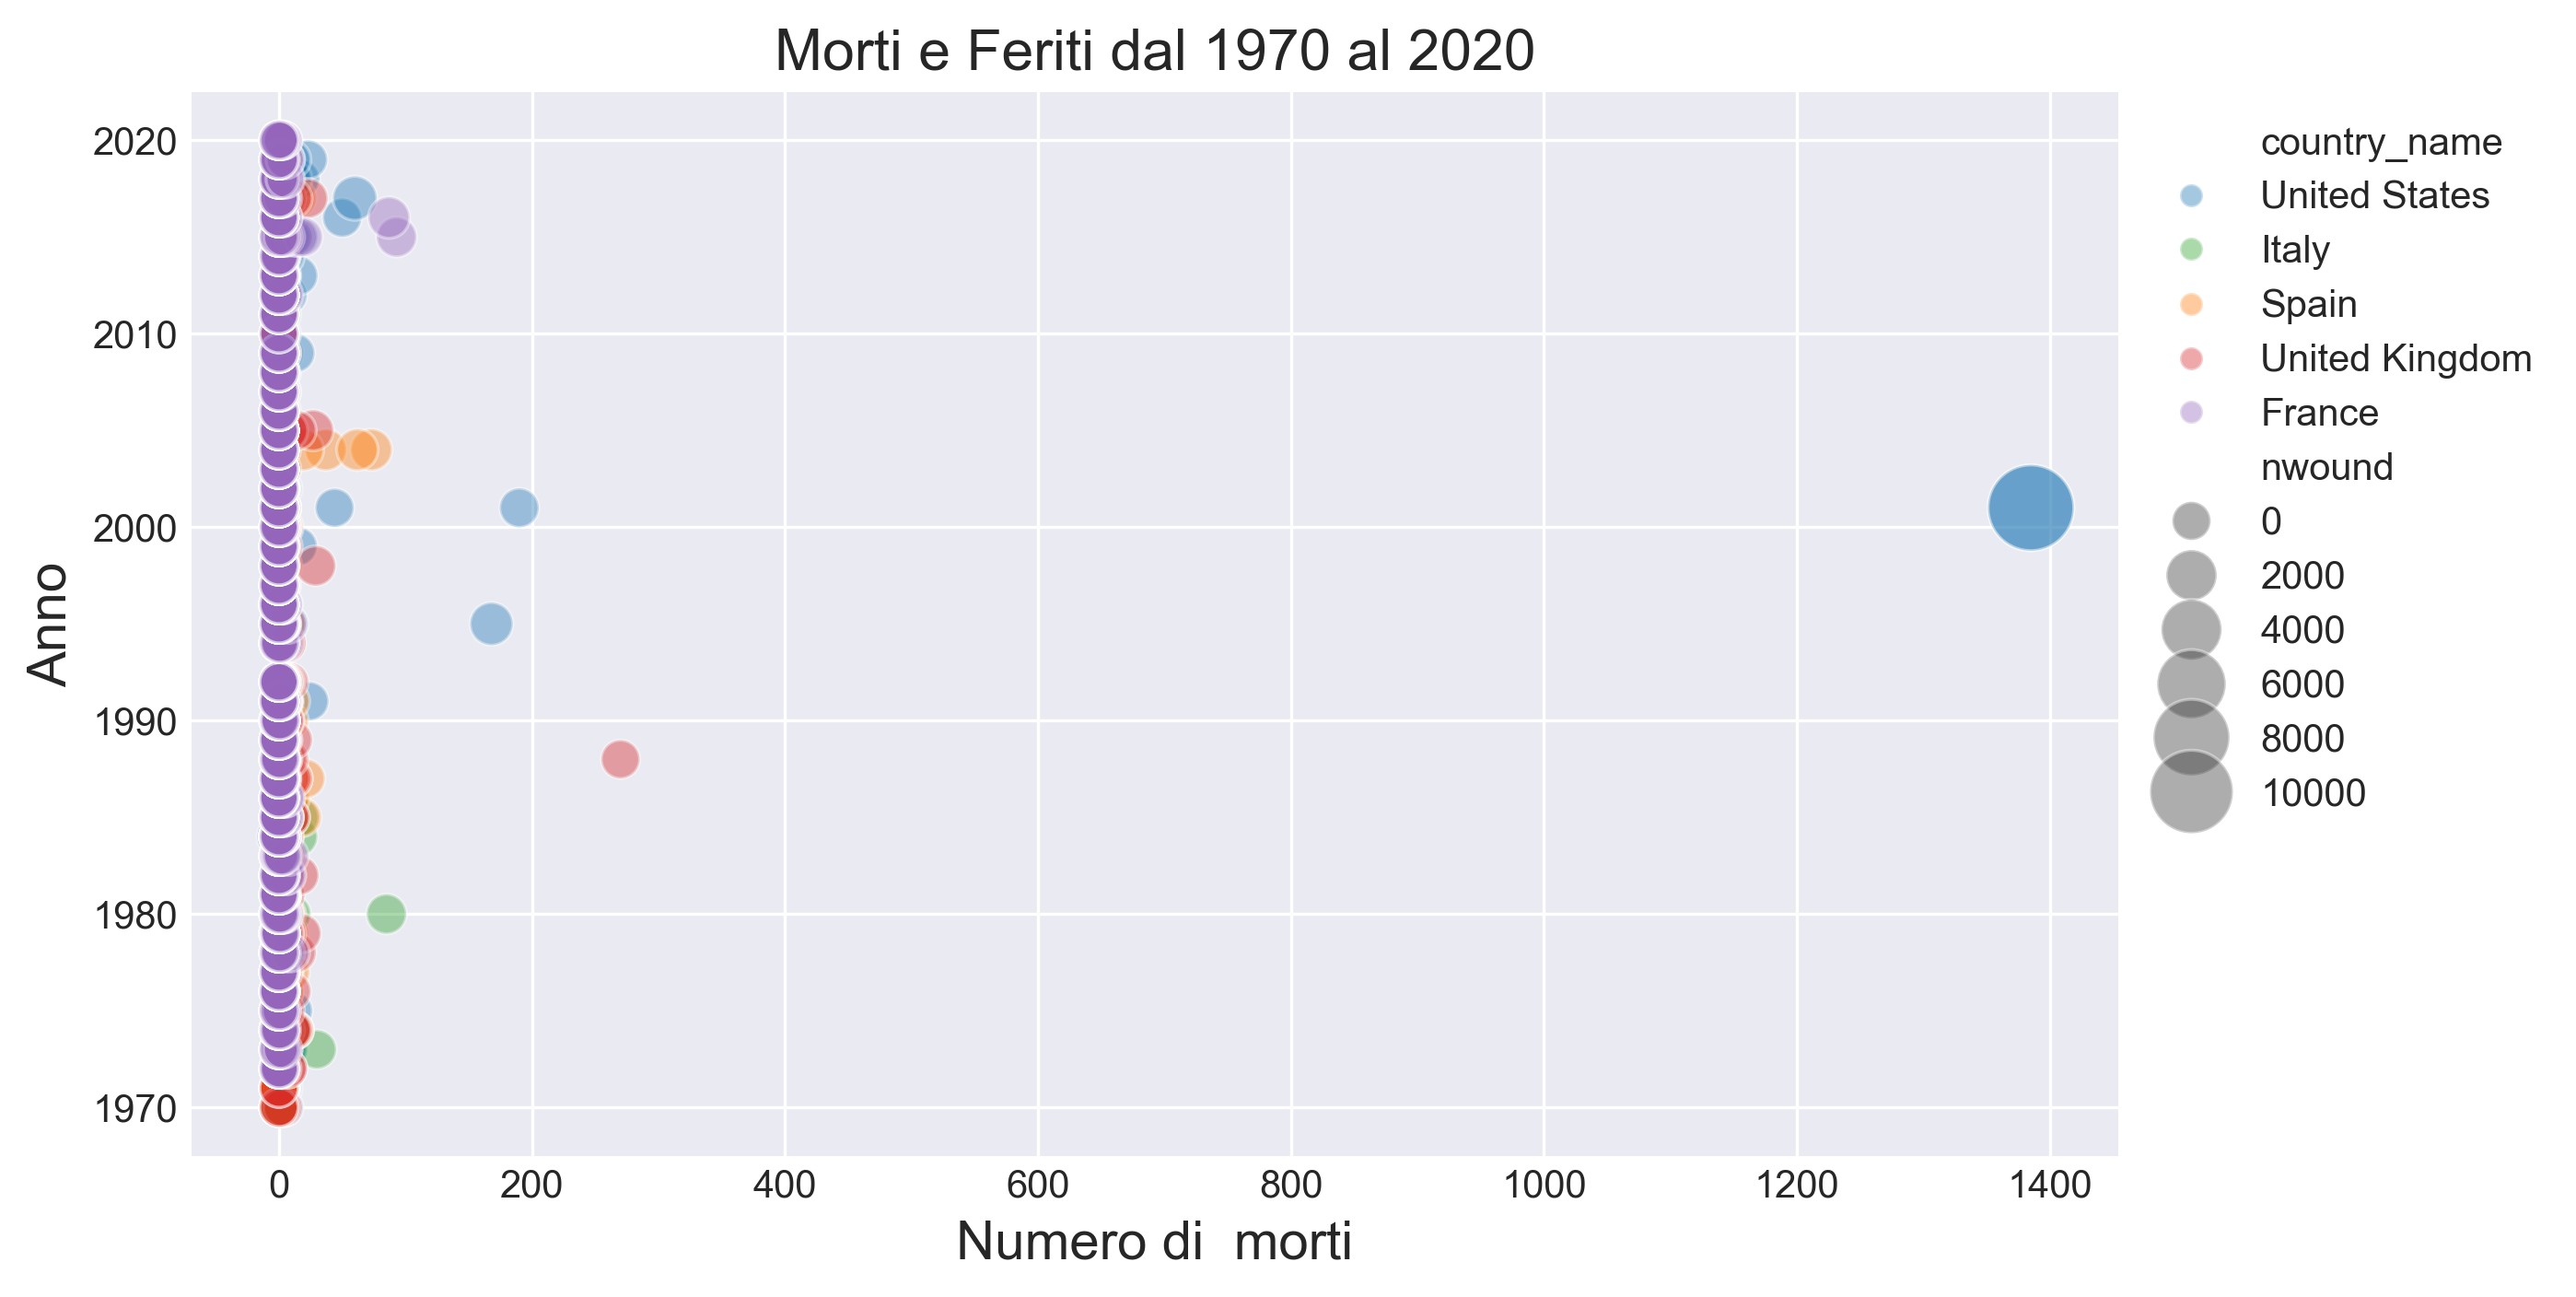

In [31]:
plt.figure(figsize=(9,5))
#plt.rc("legend", markerscale=1.2)
scatter = sns.scatterplot(
    tr, 
    x="nkill", 
    y="year", 
    alpha=0.4, 
    palette=countries_color, 
    hue="country_name",
    size="nwound",
    sizes=(100,500)
)
scatter.set_title("Morti e Feriti dal 1970 al 2020", fontsize=15)
scatter.set_xlabel("Numero di  morti", fontsize=14)
scatter.set_ylabel("Anno", fontsize=14)
sns.move_legend(scatter, "upper left", bbox_to_anchor=(1, 1))

### Nelle 5 nazioni, quali sono i 5 gruppi che hanno compiuto più attentati?

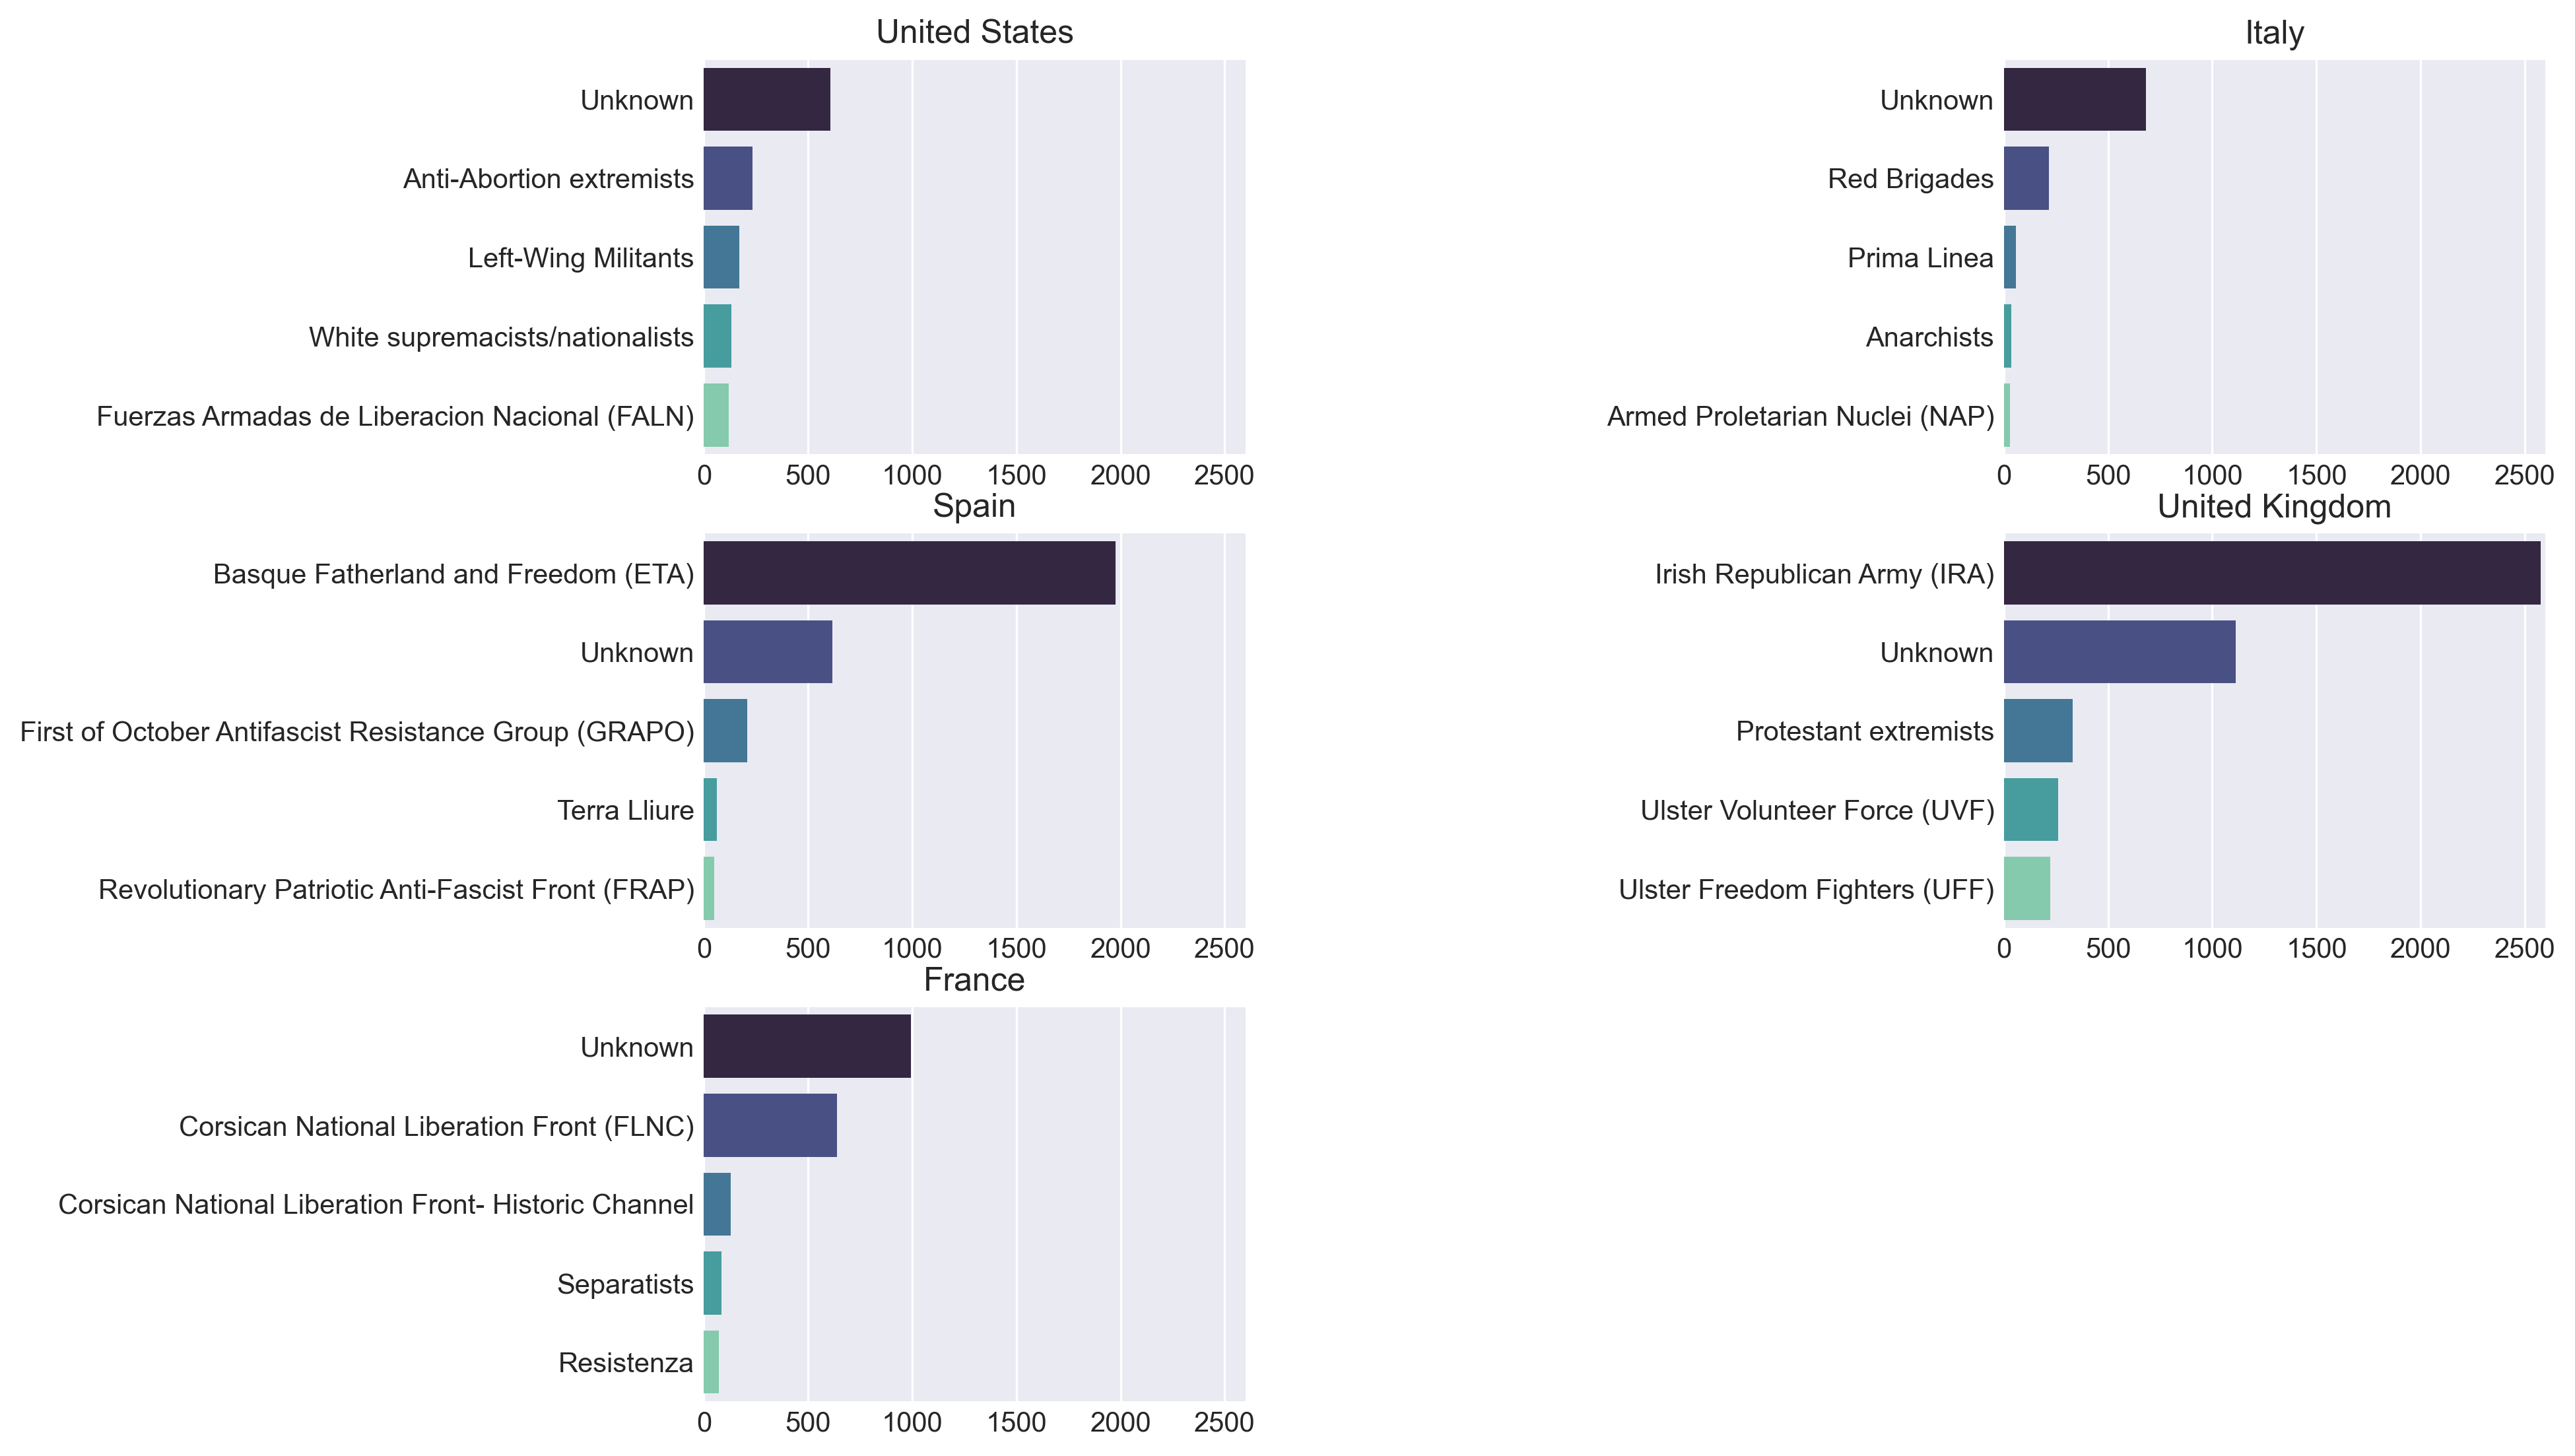

In [32]:
countries = pd.unique(tr['country_name'])
c = 0
plt.figure(figsize=(12,8.8), dpi=300)

for i in np.arange(0,7,1):

    if((i != 1) & (i != 4)): # lascio spazio in mezzo per le label delle ordinate
        plt.subplot(3, 3, i+1)
        gFreqC = tr[tr['country_name'] == countries[c]].groupby(['gname'], as_index=True).count()['day'].sort_values(ascending=False).head(5)
        gFreqC = gFreqC.reset_index().rename(columns={"day":"nAtt"})
        s = sns.barplot(gFreqC, y='gname', x='nAtt', hue="gname", palette="mako")
        #s.tick_params(axis='x', labelrotation=90)
        s.set_title(countries[c], fontsize=12)
        s.set_xlim(0,2600)
        s.set_xlabel("")
        s.set_ylabel("")
        c+=1
    else:
        c+=0

## Quali sono i gruppi terroristici che hanno fatto più vittime?

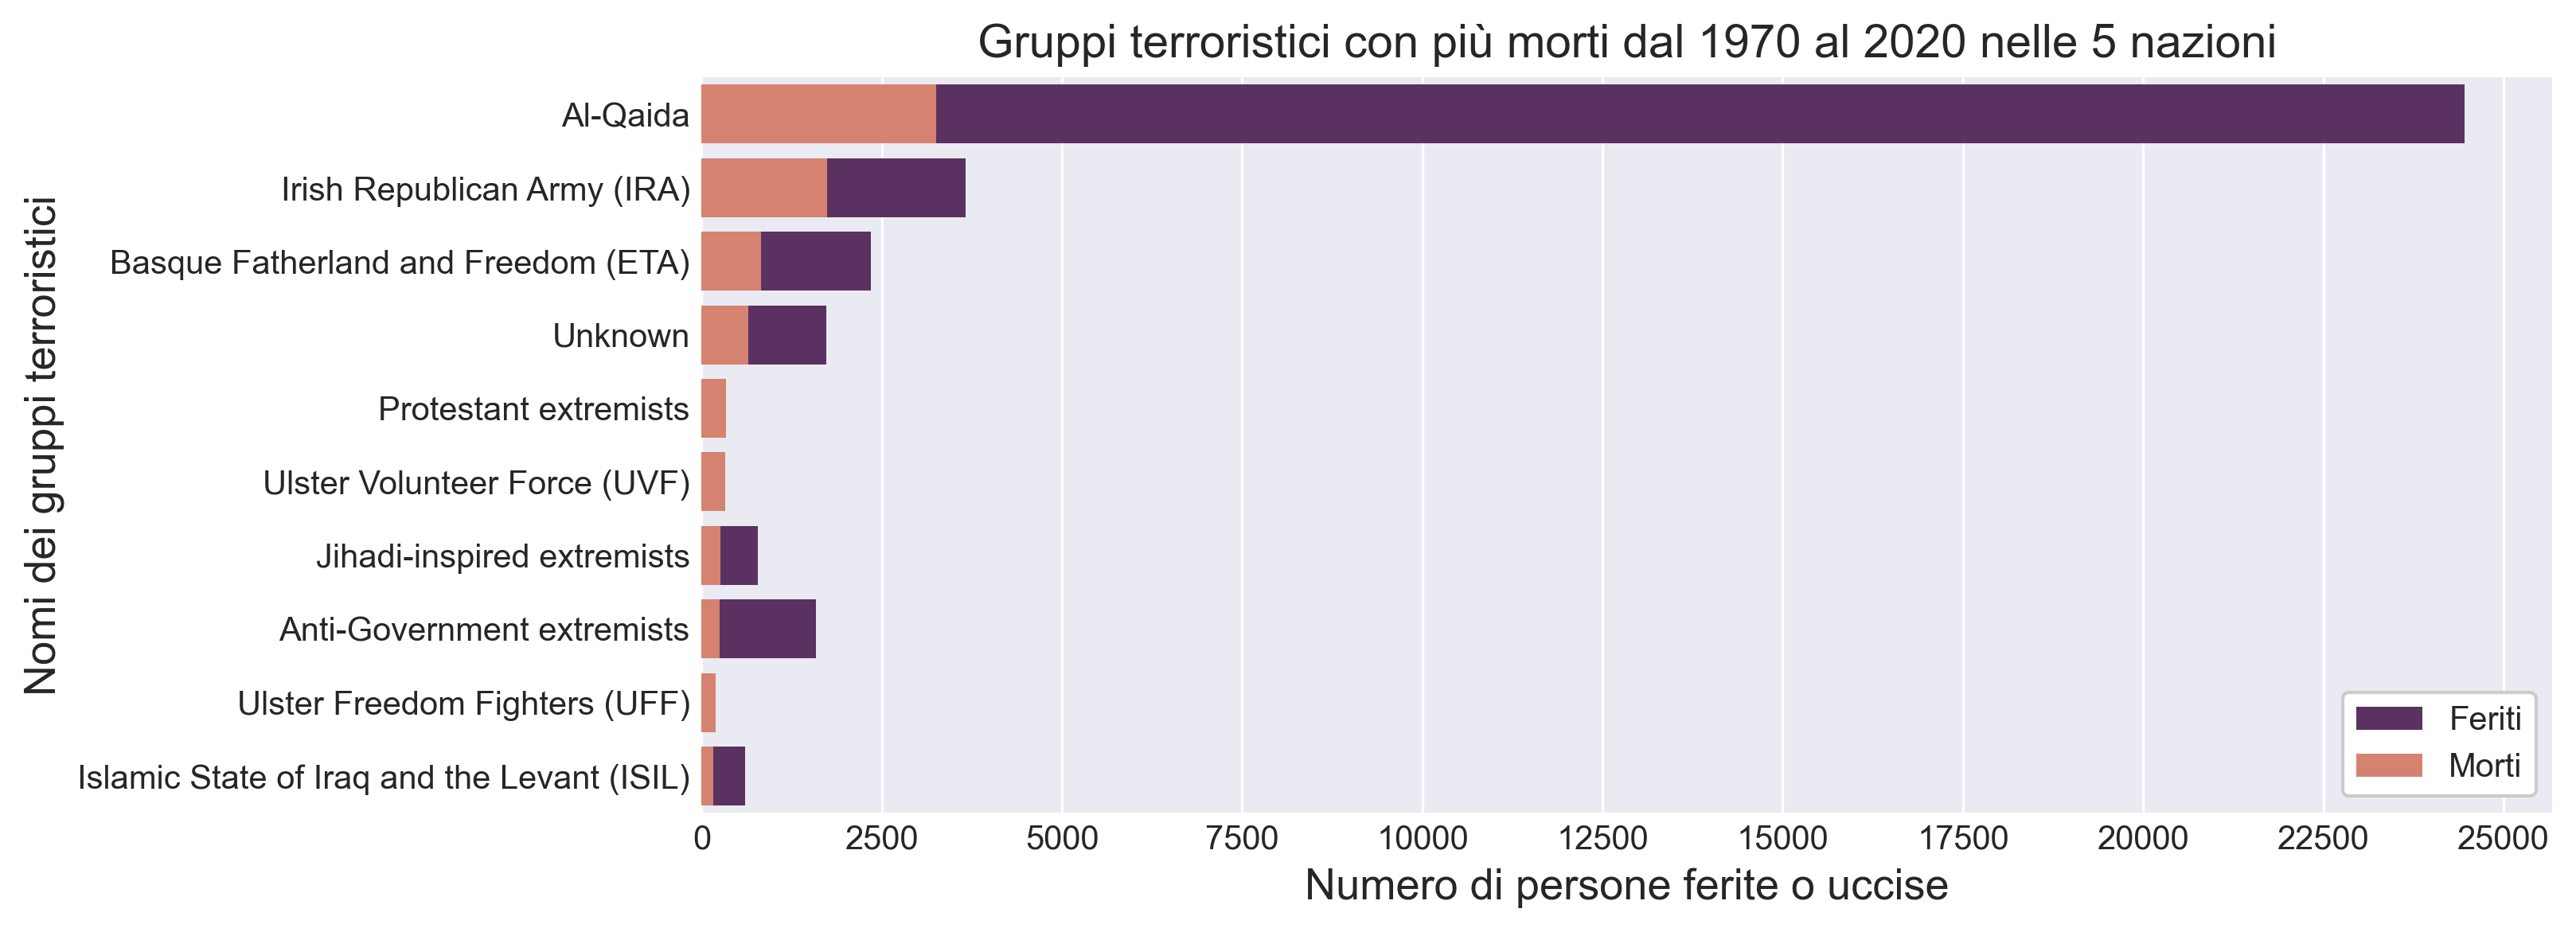

In [33]:
topGName = tr.groupby(["gname"]).sum("nkill").sort_values(by=["nkill","nwound"], ascending=False).head(10)[["nkill","nwound"]]
plt.figure(figsize=(10,4))
ax = sns.barplot(topGName, x="nwound", y="gname", label="Feriti", color="#612969")
ax = sns.barplot(topGName, x="nkill", y="gname", label="Morti", color="#E67760")
ax.set_xlabel("Numero di persone ferite o uccise",fontsize=13)
ax.set_ylabel("Nomi dei gruppi terroristici", fontsize=13)
ax.set_title("Gruppi terroristici con più morti dal 1970 al 2020 nelle 5 nazioni", fontsize=14)
plt.legend(frameon=True, facecolor="white",framealpha=1, fontsize=10)
ax.set(xticks=np.arange(0,27500,2500))

plt.show()

## Visivamente, dove sono avvenuti gli attentati che hanno segnato ogni Paese?

In [34]:
unionTopFive = pd.DataFrame()
for c in countries:
    current = tr[tr["country_name"] == c].sort_values(by="nkill",ascending=False)[["country_name","day","month","year","provstate","city","summary","gname","targtype1_txt","weaptype1_txt","nkill","nwound","latitude","longitude"]].head(5)
    unionTopFive = pd.concat([unionTopFive, current])

labels = pd.Series(["Twin Towers 1","Twin Towers 2","Pentagon attack","Oklaoma City Bombing","Las Vegas Shooting",
                    "Strage di Bologna", "Attentato di fiumicino (Settembre Nero) 1", "Attentato di fiumicino (Settembre Nero) 2", "Attentato di fiumicino (A.N.O.)", "Strage del Rapido 904",
                    "Train explodes at El Pozo Station","Train explodes near Atocha Station","Train explodes at Atocha Station", "Hipercor Bombing","Train explodes passing through Santa Eugenia Station",
                    "Fly Pan Am 103","Omagh bombing","London Metro Bombing","Manchester Bombing","Warrenpoint Ambush",
                    "Bataclan Concert Hall","Nizza massacre","La Belle Equipe bar in 11th arrondissement","Le Carillon and Le Petit Cambodge restaurants","Charlie Hebdo massacre"])

unionTopFive["annotateOnly"] = labels.values

### Stati Uniti

In [35]:
geoTr = gpd.GeoDataFrame(
    tr, geometry=gpd.points_from_xy(tr.longitude, tr.latitude)
)
geoTr.crs = "EPSG:4326"
# geoTr= geoTr.to_crs(epsg=3857) 
#geoTr.head()

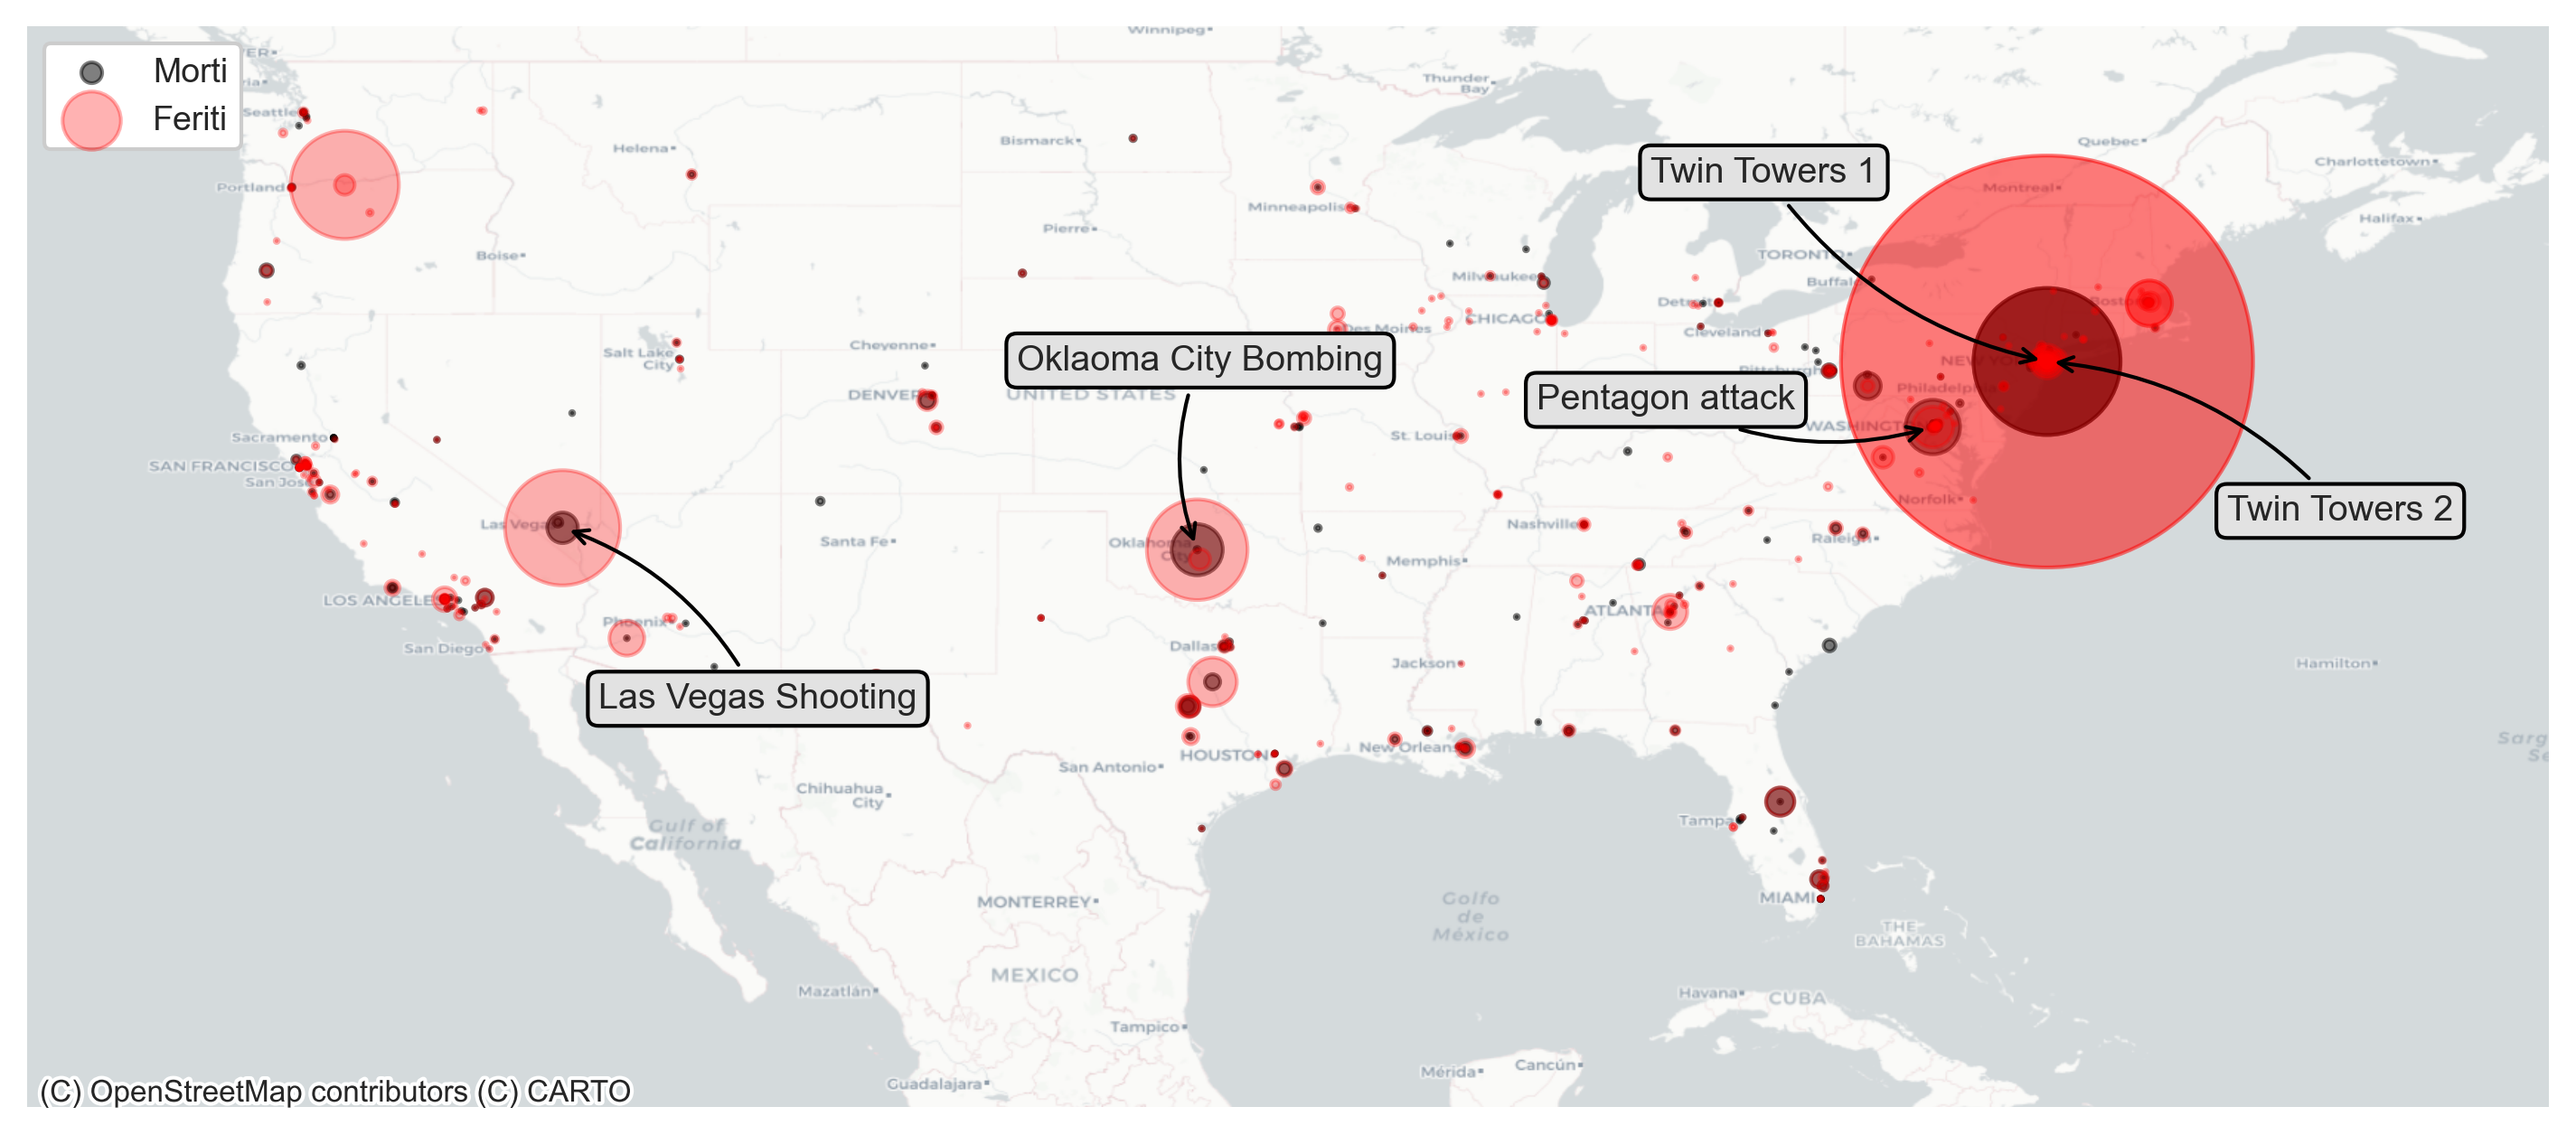

In [36]:
topUsa = unionTopFive[unionTopFive["country_name"] == "United States"]

mortiUsa = geoTr[(geoTr['country_name'] == 'United States') & (geoTr['nkill'] > 0)]
feritiUsa = geoTr[(geoTr['country_name'] == 'United States') & (geoTr['nwound'] > 0)]

mortiUsa['nkill'] *= 1.1 # scalo la visualizzazione
feritiUsa['nwound'] *= 1.1

fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xlim([-130, -60])
ax.set_ylim([20, 50])

axUsa = mortiUsa.plot(ax=ax, column='nkill', alpha=0.5, marker='o', color="black", label="Morti", markersize="nkill")
feritiUsa.plot(ax=axUsa, marker='o', color='red', alpha=0.3, label="Feriti", markersize="nwound")
ctx.add_basemap(
    axUsa,
    crs=geoTr.crs.to_string(),
    zoom=5,
    source=ctx.providers.CartoDB.Positron
    #source=ctx.providers.OpenStreetMap.Mapnik
)

axUsa.legend(frameon=True, loc="upper left", markerscale=0.2, facecolor="white", framealpha=1, fontsize=9)
axUsa.set_axis_off()

#axUsa.get_figure().savefig("usaImg.pdf",format="pdf")

#   Putroppo automatizzando il processo le coordinate delle label non erano troppo modificabili e si accumulavano una sopra l'altra.
#   Quindi, ho mantenuto lo stile iterabile per riutillizare il lavoro svolto.
'''
for l in range(0, length):
    axIta.annotate(topIta.iloc[l,:]["annotateOnly"],
                    xy=(topIta.iloc[l,:]["longitude"], topIta.iloc[l,:]["latitude"]), 
                 xytext=(topIta.iloc[l,:]["longitude"]-random.randint(2, 4), topIta.iloc[l,:]["latitude"]-random.randint(1, 2)), xycoords='data', textcoords='data',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
'''
axUsa.annotate(topUsa.iloc[0,:]["annotateOnly"],
                xy=(topUsa.iloc[0,:]["longitude"], topUsa.iloc[0,:]["latitude"]), 
                xytext=(topUsa.iloc[0,:]["longitude"]-11, topUsa.iloc[0,:]["latitude"]+5), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9.5,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axUsa.annotate(topUsa.iloc[2,:]["annotateOnly"],
                xy=(topUsa.iloc[2,:]["longitude"], topUsa.iloc[2,:]["latitude"]), 
                xytext=(topUsa.iloc[2,:]["longitude"]-11, topUsa.iloc[2,:]["latitude"]+0.5), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9.5,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axUsa.annotate(topUsa.iloc[1,:]["annotateOnly"],
                xy=(topUsa.iloc[1,:]["longitude"], topUsa.iloc[1,:]["latitude"]), 
                xytext=(topUsa.iloc[1,:]["longitude"]+5, topUsa.iloc[1,:]["latitude"]-4.4), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9.5,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axUsa.annotate(topUsa.iloc[3,:]["annotateOnly"],
                xy=(topUsa.iloc[3,:]["longitude"], topUsa.iloc[3,:]["latitude"]), 
                xytext=(topUsa.iloc[3,:]["longitude"]-5, topUsa.iloc[3,:]["latitude"]+5), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9.5,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axUsa.annotate(topUsa.iloc[4,:]["annotateOnly"],
                xy=(topUsa.iloc[4,:]["longitude"], topUsa.iloc[4,:]["latitude"]), 
                xytext=(topUsa.iloc[4,:]["longitude"]+1, topUsa.iloc[4,:]["latitude"]-5), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9.5,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
plt.show()

### Regno Unito

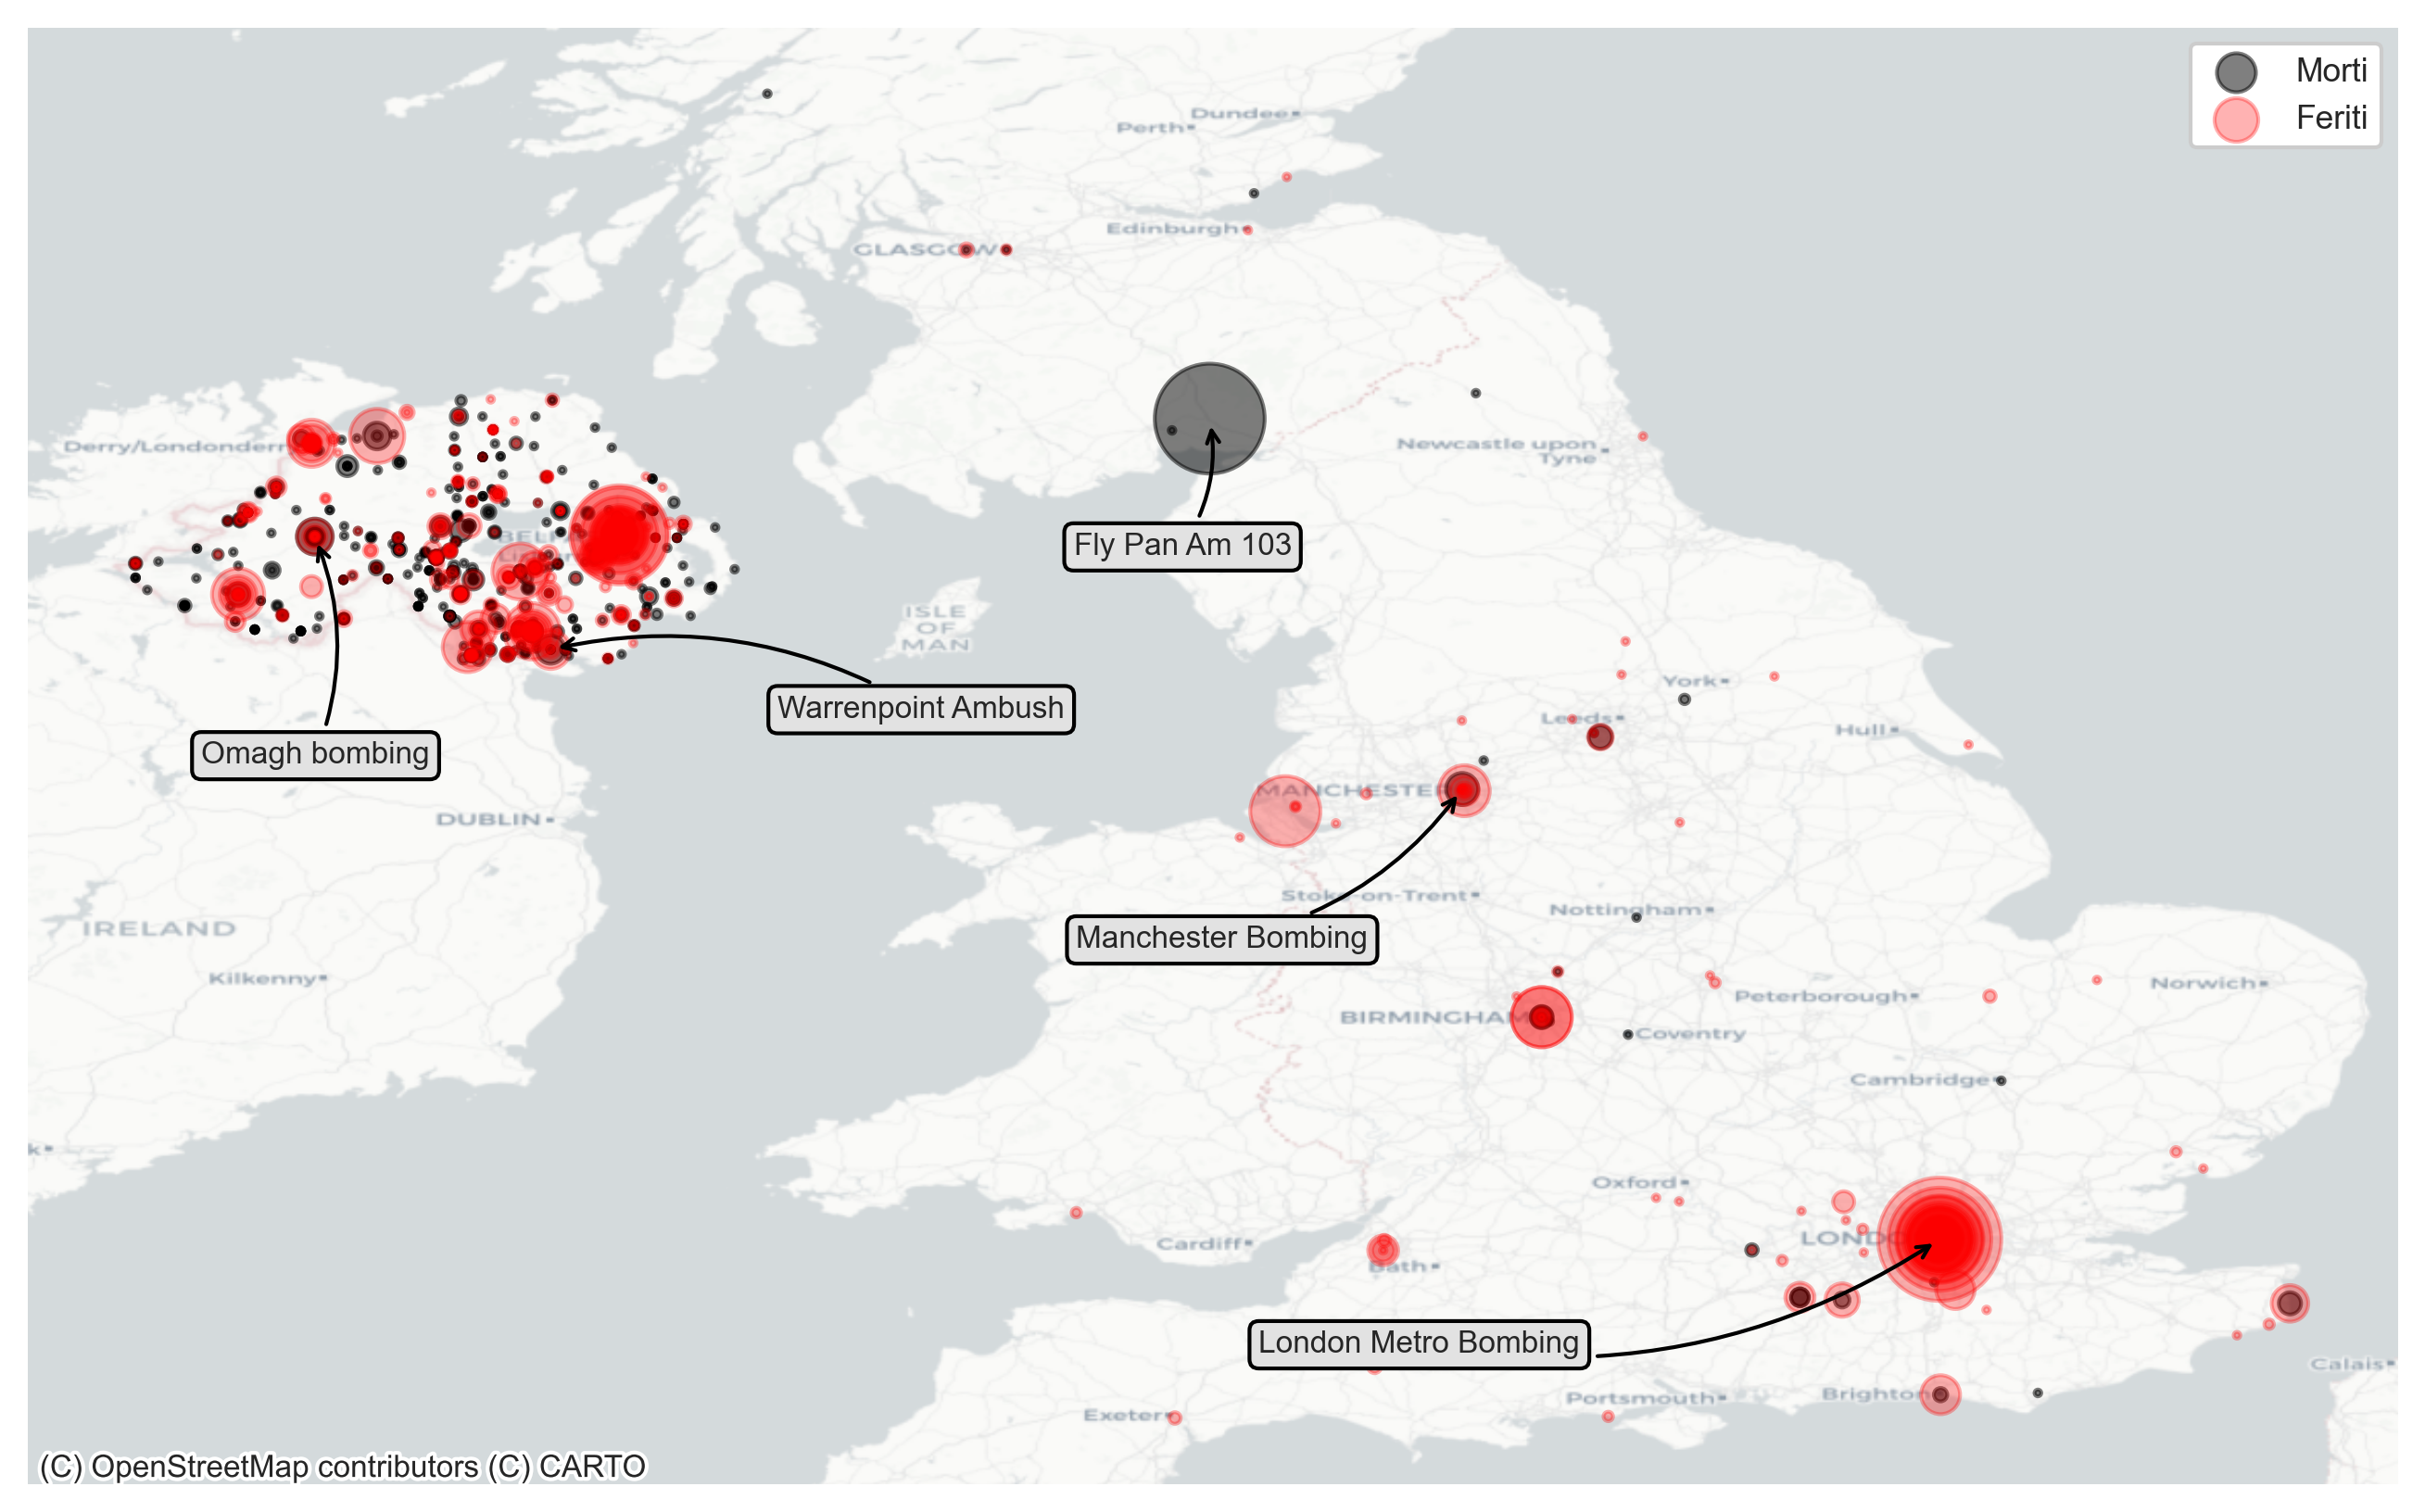

In [37]:
topUk = unionTopFive[unionTopFive["country_name"] == "United Kingdom"]

mortiUk = geoTr[(geoTr['country_name'] == 'United Kingdom') & (geoTr['nkill'] > 0)]
feritiUk = geoTr[(geoTr['country_name'] == 'United Kingdom') & (geoTr['nwound'] > 0)]

mortiUk['nkill'] *= 3 #in modo da ingrandire i marker dinamicamente
feritiUk['nwound'] *= 3

axUk = mortiUk.plot(column='nkill', alpha=0.5, marker='o', color="black", label="Morti", figsize=(11, 11), markersize="nkill")
feritiUk.plot(ax=axUk, marker='o', color='red', alpha=0.3, label="Feriti",figsize=(11, 11), markersize="nwound")
ctx.add_basemap(
    axUk,
    crs=geoTr.crs.to_string(),
    zoom=7,
    source=ctx.providers.CartoDB.Positron
    #source=ctx.providers.OpenStreetMap.Mapnik
)
axUk.legend(frameon=True, markerscale=0.5, facecolor="white", framealpha=1, fontsize=8.5)
axUk.set_axis_off()
#axUk.get_figure().savefig("ukImg.pdf",format="pdf")

axUk.annotate(topUk.iloc[0,:]["annotateOnly"],
                xy=(topUk.iloc[0,:]["longitude"], topUk.iloc[0,:]["latitude"]), 
                xytext=(topUk.iloc[0,:]["longitude"]-0.6, topUk.iloc[0,:]["latitude"]-0.6), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=8,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axUk.annotate(topUk.iloc[2,:]["annotateOnly"],
                xy=(topUk.iloc[2,:]["longitude"], topUk.iloc[2,:]["latitude"]), 
                xytext=(topUk.iloc[2,:]["longitude"]-3, topUk.iloc[2,:]["latitude"]-0.5), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=8,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axUk.annotate(topUk.iloc[1,:]["annotateOnly"],
                xy=(topUk.iloc[1,:]["longitude"], topUk.iloc[1,:]["latitude"]), 
                xytext=(topUk.iloc[1,:]["longitude"]-0.5, topUk.iloc[1,:]["latitude"]-1), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=8,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axUk.annotate(topUk.iloc[3,:]["annotateOnly"],
                xy=(topUk.iloc[3,:]["longitude"], topUk.iloc[3,:]["latitude"]), 
                xytext=(topUk.iloc[3,:]["longitude"]-1.7, topUk.iloc[3,:]["latitude"]-0.7), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=8,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axUk.annotate(topUk.iloc[4,:]["annotateOnly"],
                xy=(topUk.iloc[4,:]["longitude"], topUk.iloc[4,:]["latitude"]), 
                xytext=(topUk.iloc[4,:]["longitude"]+1, topUk.iloc[4,:]["latitude"]-0.3), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=8,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
plt.show()

### Spagna

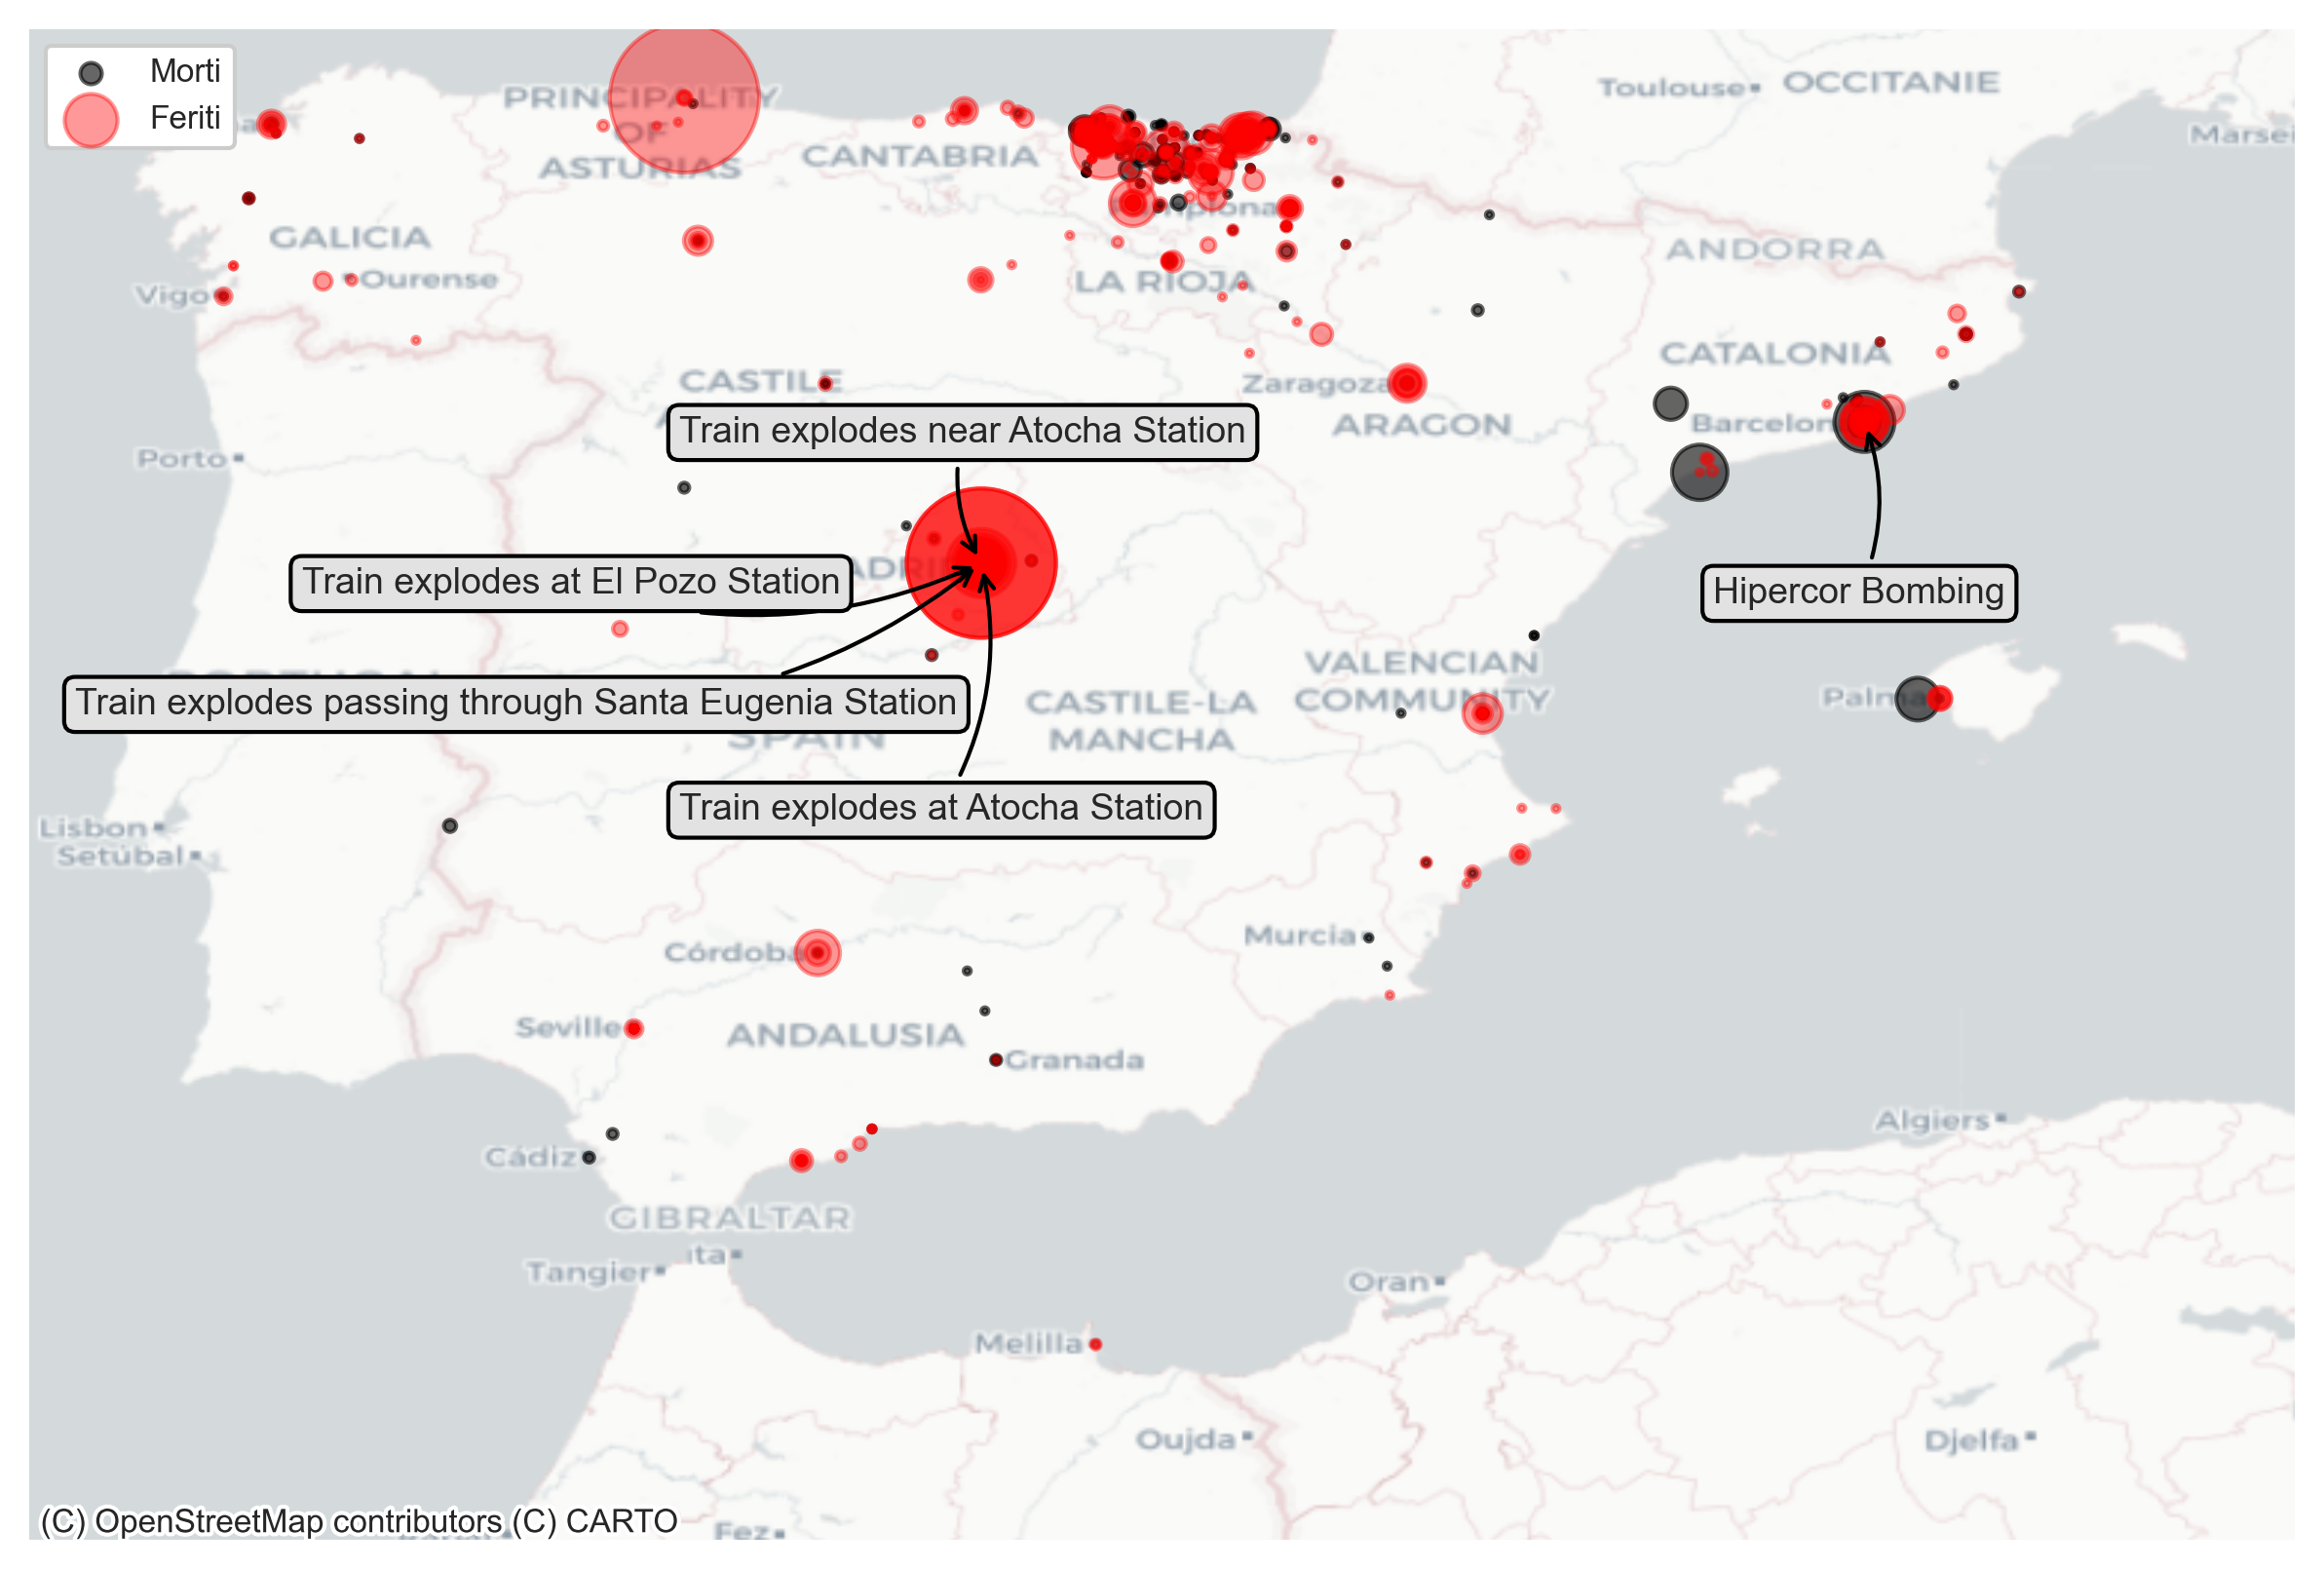

In [38]:
topEsp = unionTopFive[unionTopFive["country_name"] == "Spain"]

mortiEsp = geoTr[(geoTr['country_name'] == 'Spain') & (geoTr['nkill'] > 0)]
feritiEsp = geoTr[(geoTr['country_name'] == 'Spain') & (geoTr['nwound'] > 0)]

mortiEsp['nkill'] *= 3 #in modo da ingrandire i marker dinamicamente
feritiEsp['nwound'] *= 3

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim([-10, 5])
ax.set_ylim([34, 44])

axEsp = mortiEsp.plot(ax = ax, column='nkill', alpha=0.6, marker='o', color="black", label="Morti", markersize="nkill")
feritiEsp.plot(ax=axEsp, marker='o', color='red', alpha=0.4, label="Feriti", markersize="nwound")
ctx.add_basemap(
    axEsp,
    crs=geoTr.crs.to_string(),
    zoom=6,
    source=ctx.providers.CartoDB.Positron,
    #source=ctx.providers.OpenStreetMap.Mapnik
)
axEsp.legend(frameon=True, loc="upper left", markerscale=0.5, facecolor="white", framealpha=1, fontsize=8)
axEsp.set_axis_off()
#axEsp.get_figure().savefig("ukImg.pdf",format="pdf")
axEsp.annotate(topEsp.iloc[0,:]["annotateOnly"],
                xy=(topEsp.iloc[0,:]["longitude"], topEsp.iloc[0,:]["latitude"]), 
                xytext=(topEsp.iloc[0,:]["longitude"]-4.5, topEsp.iloc[0,:]["latitude"]-0.2), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axEsp.annotate(topEsp.iloc[2,:]["annotateOnly"],
                xy=(topEsp.iloc[2,:]["longitude"], topEsp.iloc[2,:]["latitude"]), 
                xytext=(topEsp.iloc[2,:]["longitude"]-2, topEsp.iloc[2,:]["latitude"]-1.7), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axEsp.annotate(topEsp.iloc[1,:]["annotateOnly"],
                xy=(topEsp.iloc[1,:]["longitude"], topEsp.iloc[1,:]["latitude"]), 
                xytext=(topEsp.iloc[1,:]["longitude"]-2, topEsp.iloc[1,:]["latitude"]+0.8), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axEsp.annotate(topEsp.iloc[3,:]["annotateOnly"],
                xy=(topEsp.iloc[3,:]["longitude"], topEsp.iloc[3,:]["latitude"]), 
                xytext=(topEsp.iloc[3,:]["longitude"]-1, topEsp.iloc[3,:]["latitude"]-1.2), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axEsp.annotate(topEsp.iloc[4,:]["annotateOnly"],
                xy=(topEsp.iloc[4,:]["longitude"], topEsp.iloc[4,:]["latitude"]), 
                xytext=(topEsp.iloc[4,:]["longitude"]-6, topEsp.iloc[4,:]["latitude"]-1), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
plt.show()

### Francia

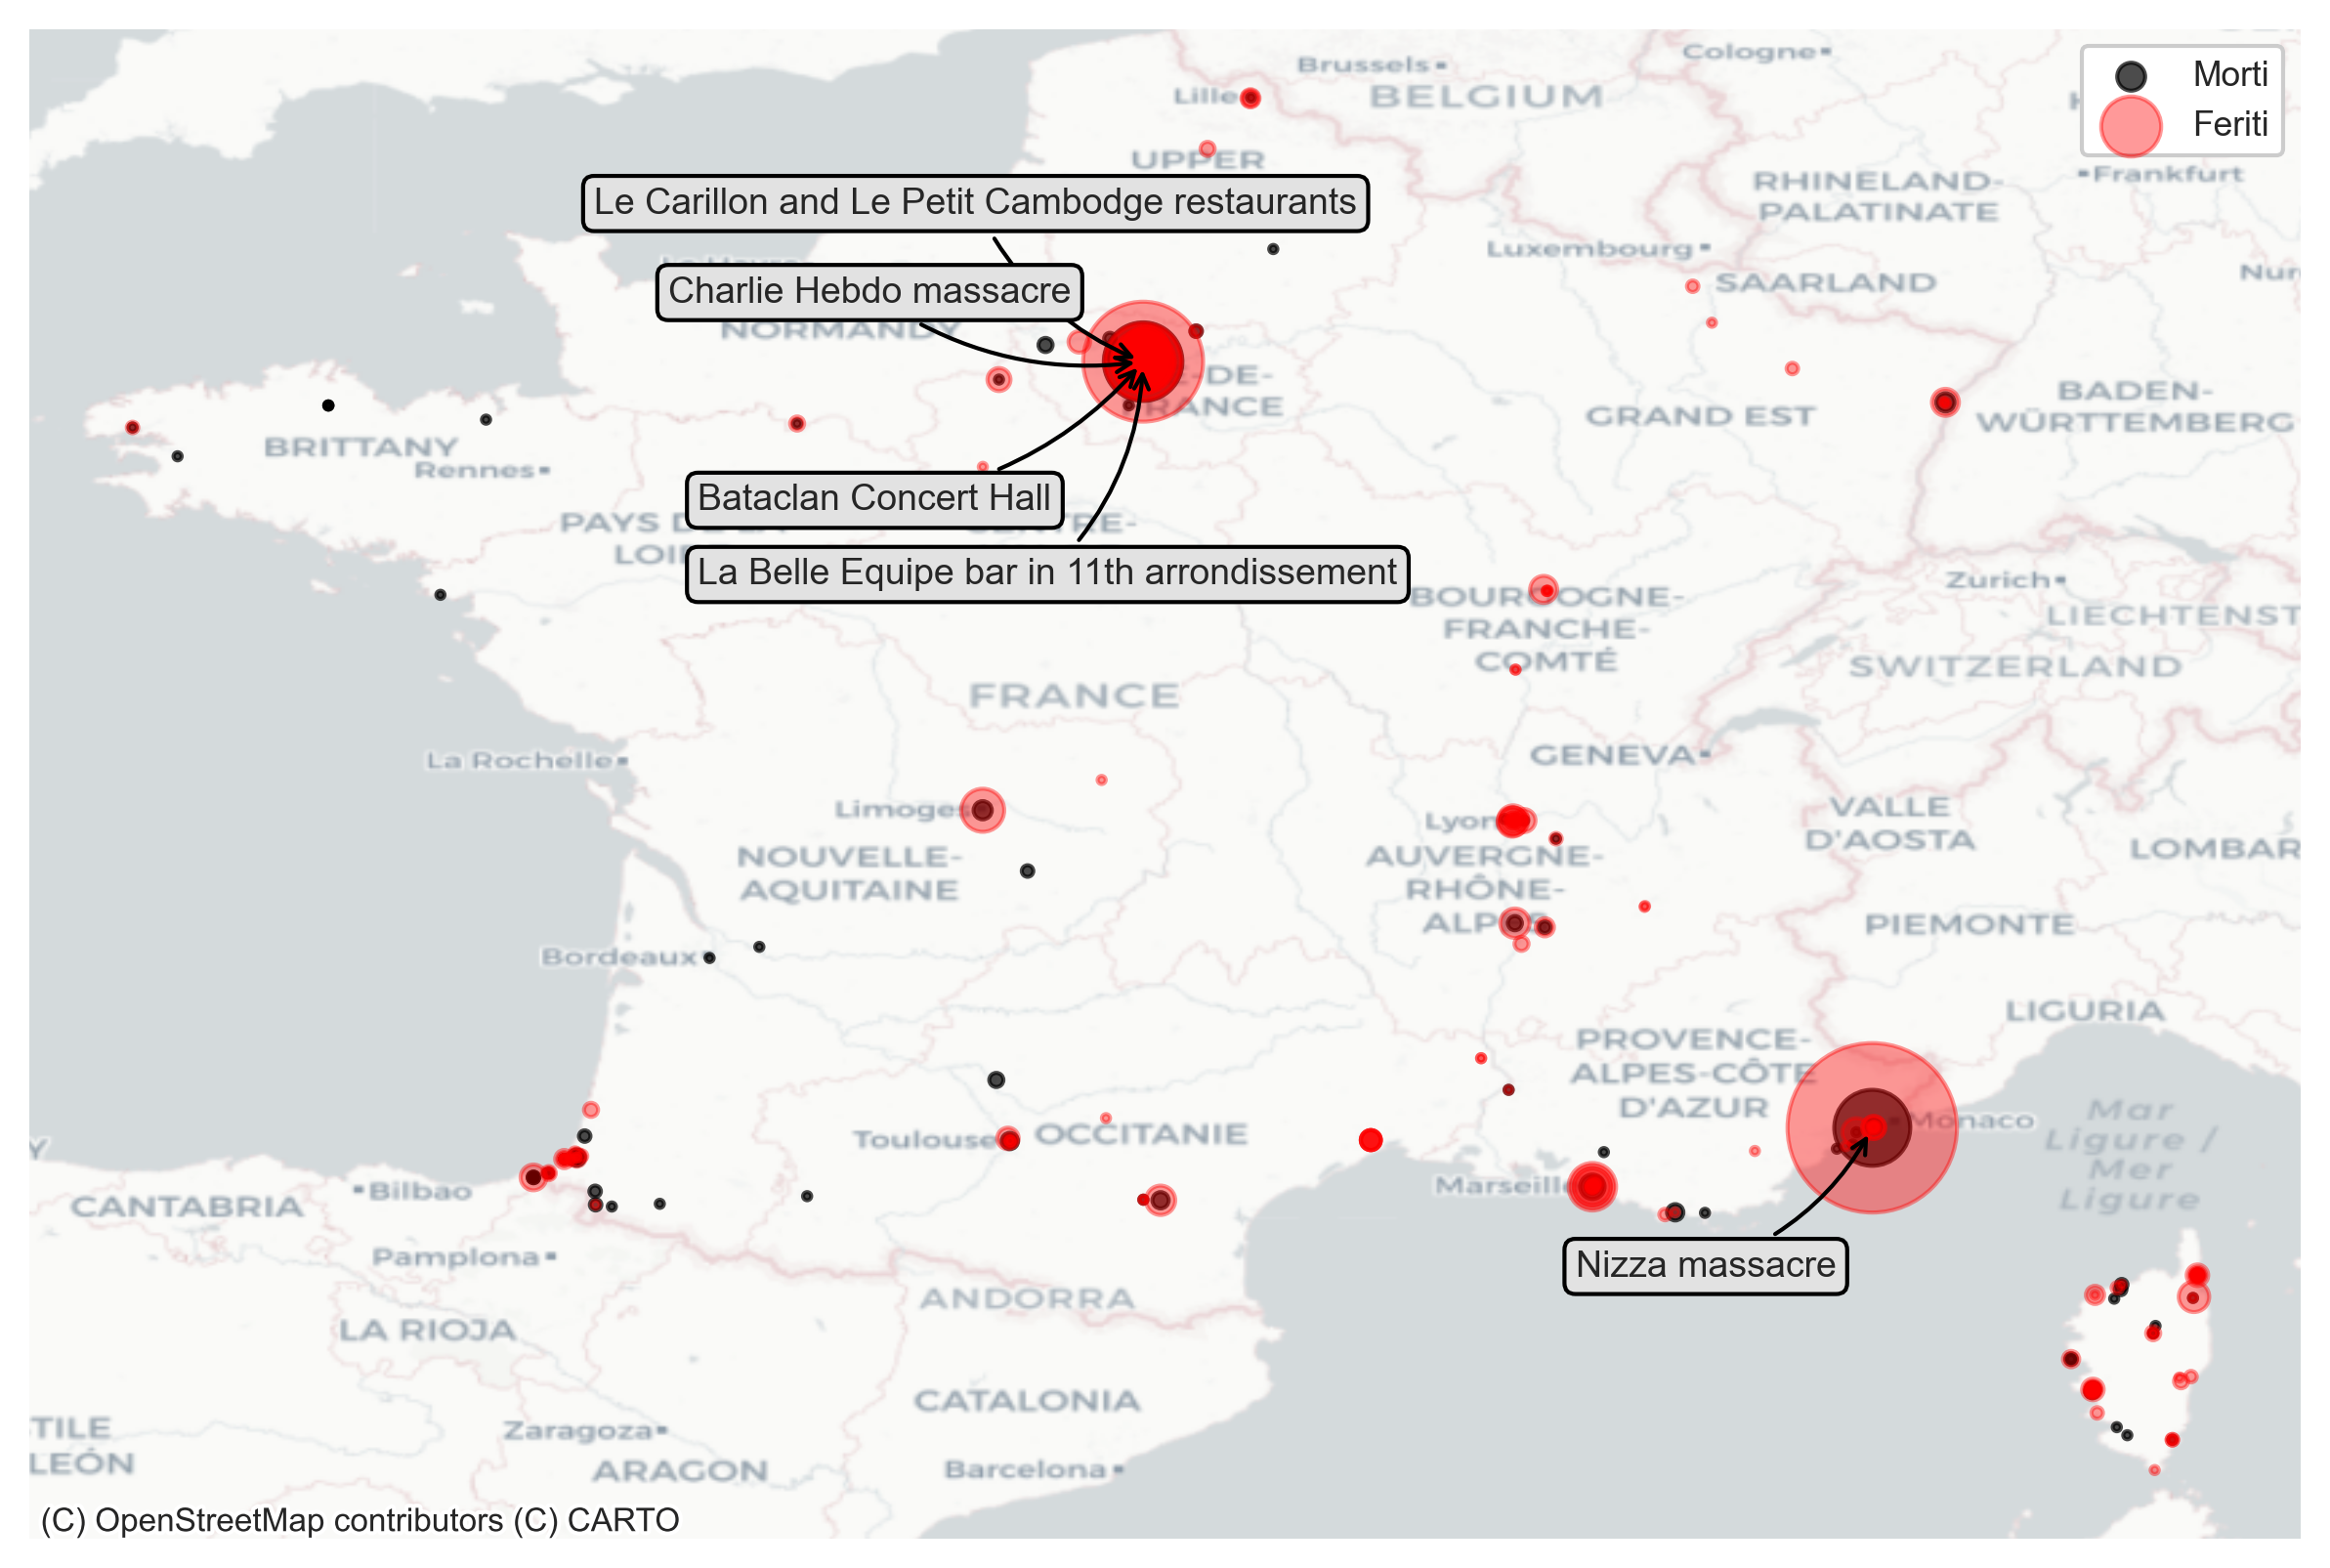

In [39]:
topFr = unionTopFive[unionTopFive["country_name"] == "France"]

mortiFr = geoTr[(geoTr['country_name'] == 'France') & (geoTr['nkill'] > 0)]
feritiFr = geoTr[(geoTr['country_name'] == 'France') & (geoTr['nwound'] > 0)]

mortiFr['nkill'] *= 4 #in modo da ingrandire i marker dinamicamente
feritiFr['nwound'] *= 4

fig, ax = plt.subplots(figsize=(10,10))
axFr = mortiFr.plot(ax=ax, column='nkill', alpha=0.7, marker='o', color="black", label="Morti", markersize="nkill")
feritiFr.plot(ax=axFr, marker='o', color='red', alpha=0.4, label="Feriti", markersize="nwound")
ctx.add_basemap(
    axFr,
    crs=geoTr.crs.to_string(),
    zoom=6,
    source=ctx.providers.CartoDB.Positron
    #source=ctx.providers.OpenStreetMap.Mapnik
)

axFr.legend(frameon=True, markerscale=0.5,facecolor="white", framealpha=1, fontsize=8.5)
axFr.set_axis_off()
#axFr.get_figure().savefig("ukImg.pdf",format="pdf")
axFr.annotate(topFr.iloc[0,:]["annotateOnly"],
                xy=(topFr.iloc[0,:]["longitude"], topFr.iloc[0,:]["latitude"]), 
                xytext=(topFr.iloc[0,:]["longitude"]-3, topFr.iloc[0,:]["latitude"]-1), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axFr.annotate(topFr.iloc[2,:]["annotateOnly"],
                xy=(topFr.iloc[2,:]["longitude"], topFr.iloc[2,:]["latitude"]), 
                xytext=(topFr.iloc[2,:]["longitude"]-3, topFr.iloc[2,:]["latitude"]-1.5), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axFr.annotate(topFr.iloc[1,:]["annotateOnly"],
                xy=(topFr.iloc[1,:]["longitude"], topFr.iloc[1,:]["latitude"]), 
                xytext=(topFr.iloc[1,:]["longitude"]-2, topFr.iloc[1,:]["latitude"]-1), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axFr.annotate(topFr.iloc[3,:]["annotateOnly"],
                xy=(topFr.iloc[3,:]["longitude"], topFr.iloc[3,:]["latitude"]), 
                xytext=(topFr.iloc[3,:]["longitude"]-3.7, topFr.iloc[3,:]["latitude"]+1), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axFr.annotate(topFr.iloc[4,:]["annotateOnly"],
                xy=(topFr.iloc[4,:]["longitude"], topFr.iloc[4,:]["latitude"]), 
                xytext=(topFr.iloc[4,:]["longitude"]-3.2, topFr.iloc[4,:]["latitude"]+0.4), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
plt.show()

### Italia

In [40]:
# url = "https://github.com/openpolis/geojson-italy/blob/master/geojson/limits_IT_regions.geojson"
itaMapName = "limits_IT_regions.geojson"
pathItaMap = os.path.abspath(os.path.join(os.pardir, "data", "itaMap"))

regItaAtt = tr[tr['country_name'] == 'Italy'].groupby("provstate").count()['day']
geoRegioniItalia = gpd.read_file(os.path.join(pathItaMap, itaMapName))
geoAttentatiItaTOT = geoRegioniItalia.merge(regItaAtt,left_on="reg_name", right_on="provstate", how="inner").rename(columns={"day":"nAtt"})

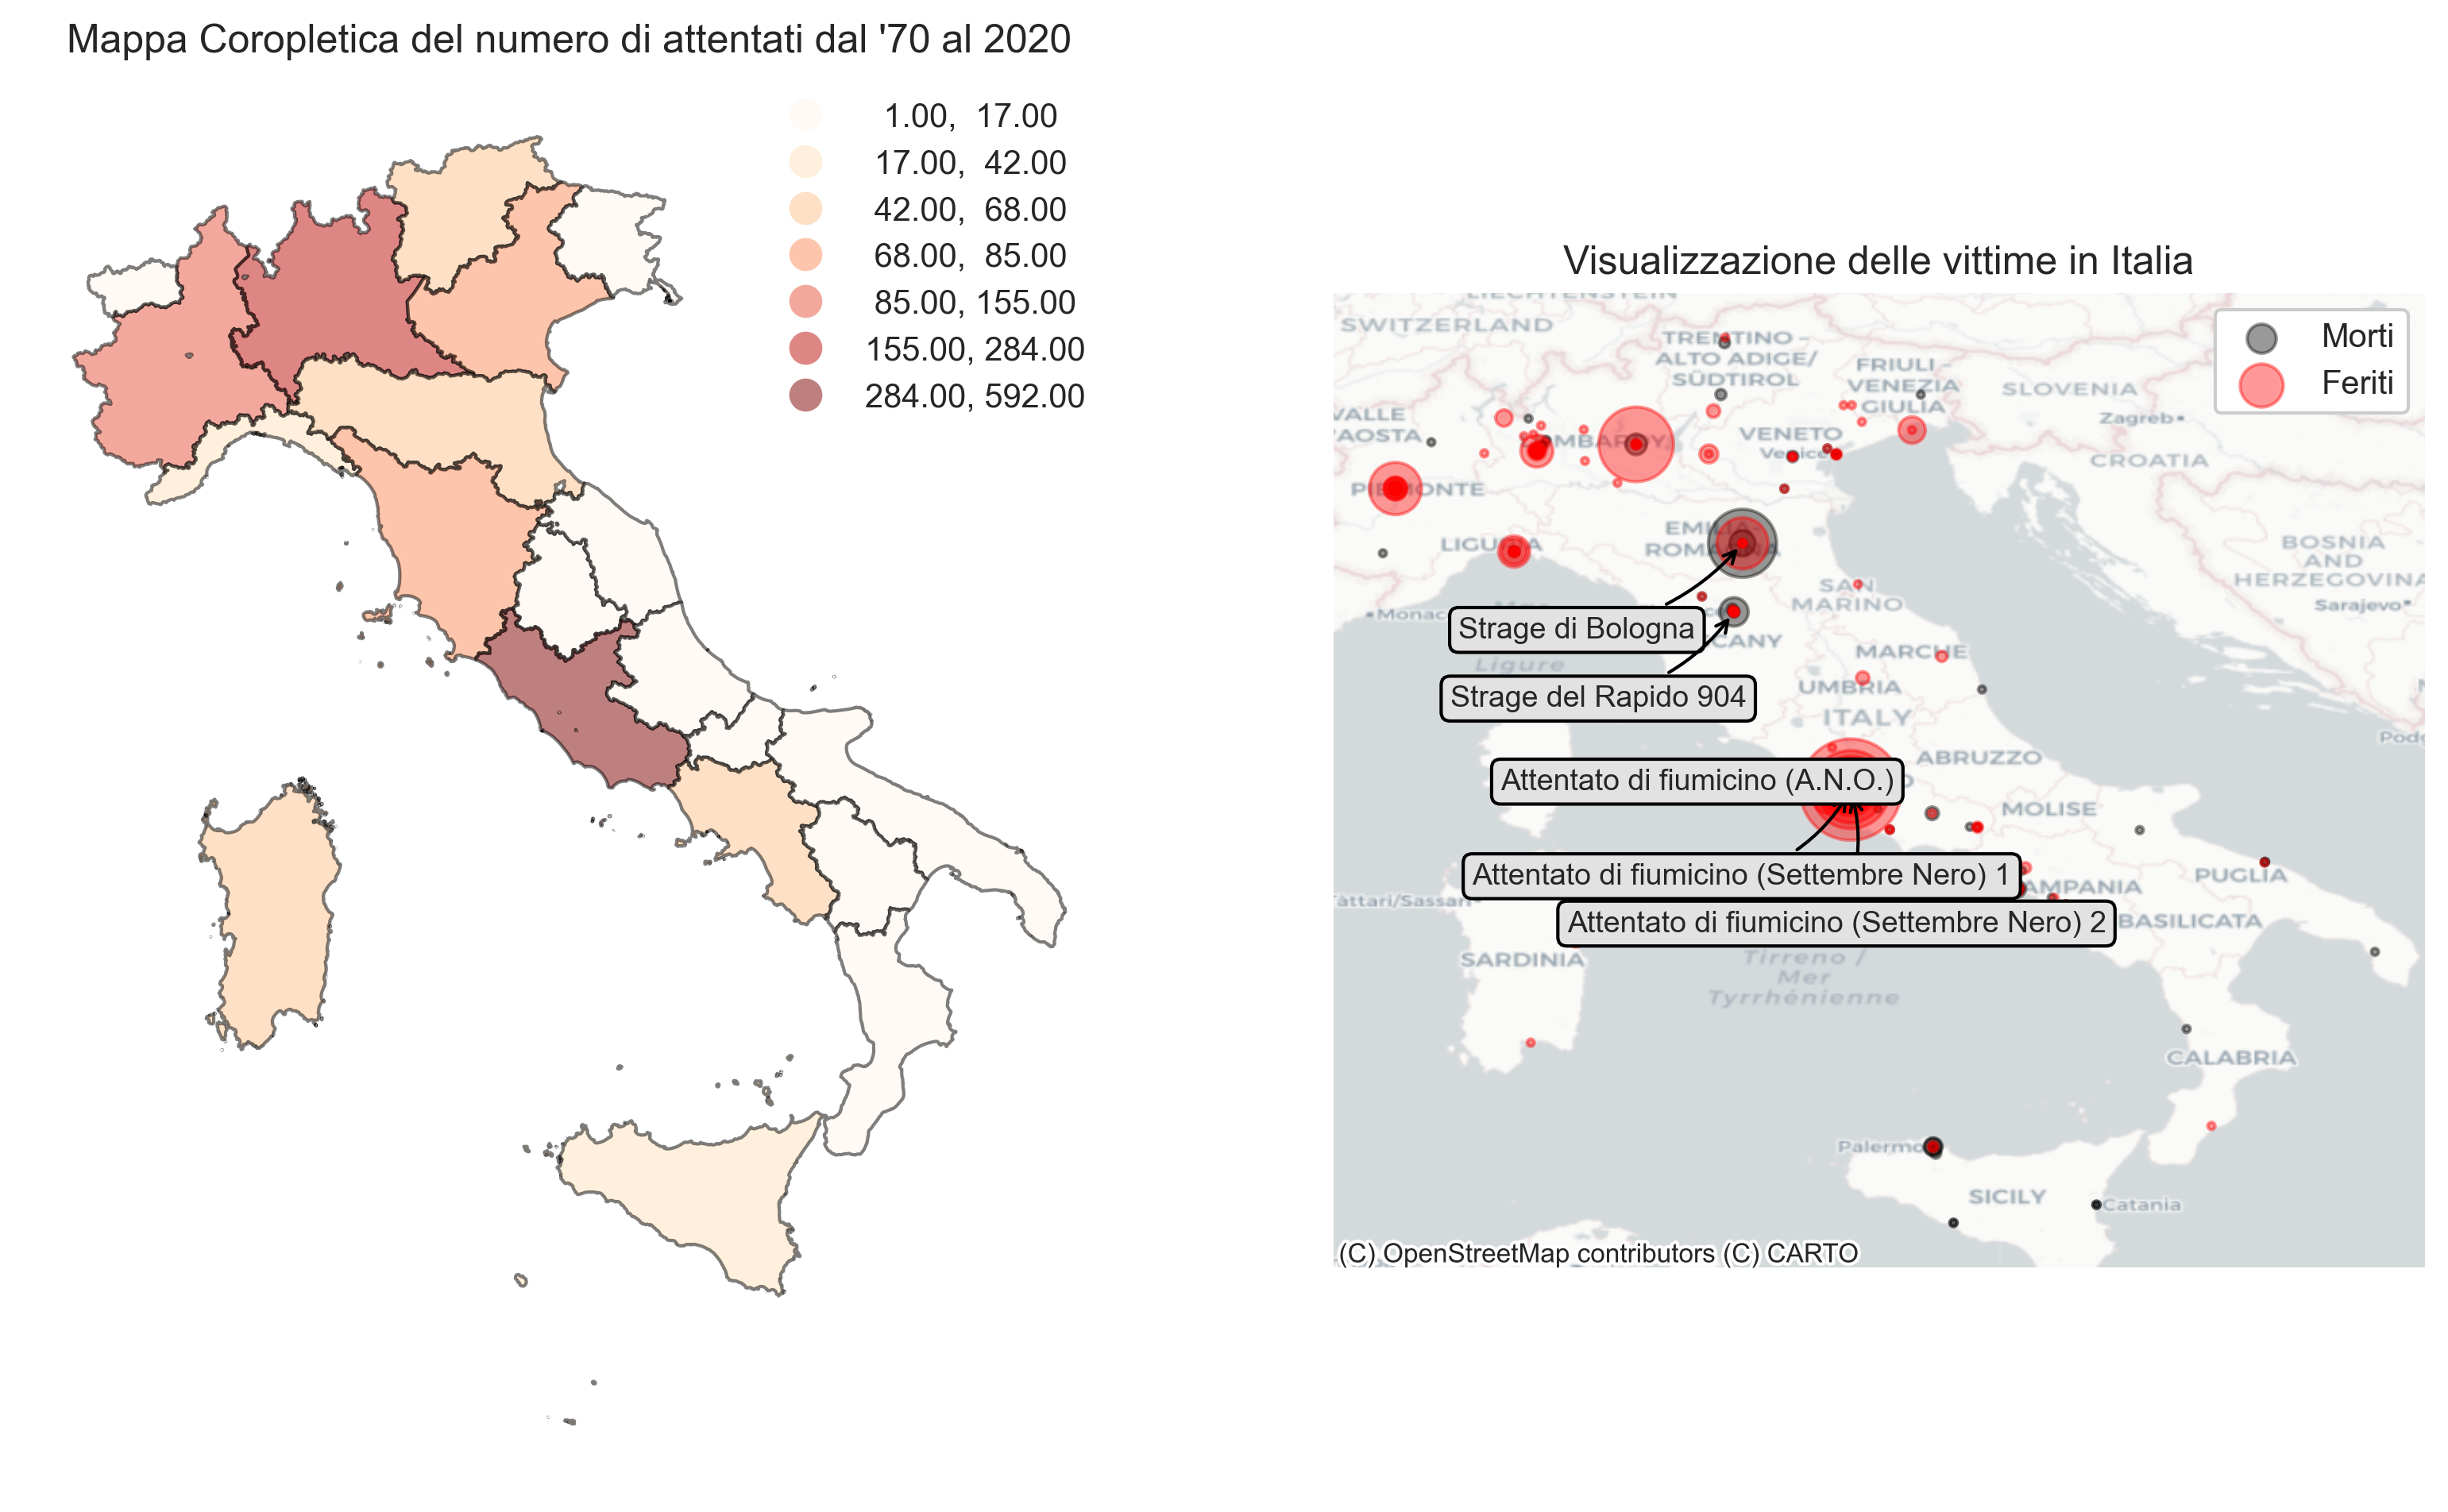

In [41]:
topIta = unionTopFive[unionTopFive["country_name"] == "Italy"]

mortiIta = geoTr[(geoTr['country_name'] == 'Italy') & (geoTr['nkill'] > 0)]
feritiIta = geoTr[(geoTr['country_name'] == 'Italy') & (geoTr['nwound'] > 0)]

mortiIta['nkill'] *= 5 # scalo la visualizzazione dei marker nel grafico in modo da renderli più visibilis
feritiIta['nwound'] *= 5

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 13))

axClor = geoAttentatiItaTOT.plot(
    ax=ax1,
    figsize=(8,8),
    column='nAtt',
    alpha=0.5, 
    edgecolor='k',
    scheme="fisher_jenks",
    k=7,
    cmap="OrRd",
    legend=True)
axClor.set_axis_off()
ax1.set_title("Mappa Coropletica del numero di attentati dal '70 al 2020")
# ax.get_figure().savefig("test.svg",format="svg")

#plt.subplot(1,2,2)
axIta = mortiIta.plot(ax=ax2, column='nkill', alpha=0.4, marker='o', color="black",label="Morti", markersize="nkill")
feritiIta.plot(ax=axIta, marker='o', color='red', alpha=0.4, label="Feriti", markersize="nwound")

ctx.add_basemap(
    axIta,
    crs=geoTr.crs.to_string(),
    zoom=6,
    source=ctx.providers.CartoDB.Positron
    #source=ctx.providers.OpenStreetMap.Mapnik
)
axIta.legend(frameon=True, markerscale=0.6, facecolor="white", framealpha=1, fontsize=10)
axIta.set_axis_off()

''' Putroppo automatizzando il processo le coordinate delle label non erano troppo modificabili e si accumulavano una sopra l'altra
for l in range(0, length):
    axIta.annotate(topIta.iloc[l,:]["annotateOnly"],
                    xy=(topIta.iloc[l,:]["longitude"], topIta.iloc[l,:]["latitude"]), 
                 xytext=(topIta.iloc[l,:]["longitude"]-random.randint(2, 4), topIta.iloc[l,:]["latitude"]-random.randint(1, 2)), xycoords='data', textcoords='data',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
'''
axIta.annotate(topIta.iloc[0,:]["annotateOnly"],
                xy=(topIta.iloc[0,:]["longitude"], topIta.iloc[0,:]["latitude"]), 
                xytext=(topIta.iloc[0,:]["longitude"]-3, topIta.iloc[0,:]["latitude"]-1), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
axIta.annotate(topIta.iloc[2,:]["annotateOnly"],
                xy=(topIta.iloc[2,:]["longitude"], topIta.iloc[2,:]["latitude"]), 
                xytext=(topIta.iloc[2,:]["longitude"]-3, topIta.iloc[2,:]["latitude"]-1.5), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
axIta.annotate(topIta.iloc[1,:]["annotateOnly"],
                xy=(topIta.iloc[1,:]["longitude"], topIta.iloc[1,:]["latitude"]), 
                xytext=(topIta.iloc[1,:]["longitude"]-4, topIta.iloc[1,:]["latitude"]-1), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
axIta.annotate(topIta.iloc[3,:]["annotateOnly"],
                xy=(topIta.iloc[3,:]["longitude"], topIta.iloc[3,:]["latitude"]), 
                xytext=(topIta.iloc[3,:]["longitude"]-3.7, topIta.iloc[3,:]["latitude"]), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
axIta.annotate(topIta.iloc[4,:]["annotateOnly"],
                xy=(topIta.iloc[4,:]["longitude"], topIta.iloc[4,:]["latitude"]), 
                xytext=(topIta.iloc[4,:]["longitude"]-3, topIta.iloc[4,:]["latitude"]-1), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
ax2.set_title("Visualizzazione delle vittime in Italia")
#axIta.get_figure().savefig("itaImg.pdf",format="pdf")
plt.show()

# Conclusioni
I punti salienti sono stati:


1.  Il _Regno Unito_ è la __nazione più colpita__ tra le cinque analizzate;
2.  Nel _Regno Unito_ la maggior parte degli attentati sono avvenuti nell' __Irlanda del Nord__
3.  Gli _Stati Uniti_ hanno l'attentato che ha avuto più __impatto__ nella storia
4.  Il _Lazio_ è la __regione più colpita__ in Italia 